# Time Series Analysis: TodoVentas S.A.

TodoVentas S.A, a prominent family-owned e-commerce company, is at a crucial juncture in its growth trajectory. Contemplating a strategic capital expansion, the company aims to understand the potential future value of the organization, specifically in terms of projected earnings.

The primary goal is to forecast daily profits for the next three months, leveraging key insights from a representative sample of sales data spanning the last year. The prediction horizon is strategically set to align with the latest available transaction date, which is December 9, 2023.

The variables include:
- Invoice Number
- Stock Code
- Description
- Quantity
- Invoice Date
- Unit Price
- Customer ID
- Country

# Importing packages

In [286]:
! pip install pmdarima

In [287]:
! pip install catboost

In [288]:
! pip install sktime

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from datetime import datetime

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.outlier_detection import HampelFilter


# Conecting to Drive

In [290]:
from google.colab import drive

# Conecto con Drive + ruta a mi archivo
drive.mount('/content/drive')

ruta_archivo = '/content/drive/MyDrive/Nuclio/online_retail_sales.csv'

df = pd.read_csv(ruta_archivo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **PART I. Initial analysis and data treatment**

# Inspecting the data

In [291]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom

In [292]:
df.tail()

InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID Country  
541904  2023-12-09 12:50:00       0.85     12680.0  France  
541905  2023-12-09 12:50:00       2.10     12680.0  France  
541906  2023-12-09 12:50:00       4.15     12680.0  France  
541907  2023-12-09 12:50:00       4.15     12680.0  France  
541908  2023-12-09 12:50:00       4.95     12680.0  France

In [293]:
df.sample(10) # i see negative q's

InvoiceNo StockCode                          Description  Quantity  \
273481    560833     22720    SET OF 3 CAKE TINS PANTRY DESIGN          3   
399125    571271    82494L          WOODEN FRAME ANTIQUE WHITE          3   
429345    573553     21931               JUMBO STORAGE BAG SUKI        13   
482543    577477     22112           CHOCOLATE HOT WATER BOTTLE         3   
461519    575943     20686    DOLLY MIXTURE CHILDREN'S UMBRELLA         3   
32876     539196    85034C          3 ROSE MORRIS BOXED CANDLES         4   
533848    581118     22277    COSMETIC BAG VINTAGE ROSE PAISLEY         6   
217877    555942     22423             REGENCY CAKESTAND 3 TIER         2   
198565    554054     22917                 HERB MARKER ROSEMARY         1   
509646    579393     21673  WHITE SPOT BLUE CERAMIC DRAWER KNOB        12   

                InvoiceDate  UnitPrice  CustomerID         Country  
273481  2023-07-21 12:14:00       4.95     16891.0  United Kingdom  
399125  2023-10-16 12:16:00       2.95     15440.0  United Kingdom  
429345  2023-10-31 13:48:00       4.13         NaN  United Kingdom  
482543  2023-11-20 11:32:00       4.95     14157.0  United Kingdom  
461519  2023-11-13 11:44:00       3.25     17920.0  United Kingdom  
32876   2022-12-16 12:09:00       4.25     18055.0  United Kingdom  
533848  2023-12-07 12:26:00       2.10     15136.0  United Kingdom  
217877  2023-06-08 10:14:00      12.75     15743.0  United Kingdom  
198565  2023-05-20 15:29:00       1.63         NaN  United Kingdom  
509646  2023-11-29 12:07:00       1.45     12627.0         Germany

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


First I'm going to transform the date column, since I'm not interested in having such granularity + I want to set it as index

In [295]:
df['InvoiceDate']=pd.to_datetime(df.InvoiceDate)
df['InvoiceDate']=df.InvoiceDate.dt.strftime('%Y-%m-%d')

Taking a look at the InvoiceDate variable, I see that my df does not contain Sundays.

In [296]:
df.set_index('InvoiceDate', inplace=True)
df.sort_index()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                            
2022-12-01     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2022-12-01     536365     71053                  WHITE METAL LANTERN   
2022-12-01     536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2022-12-01     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2022-12-01     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
...               ...       ...                                  ...   
2023-12-09     581587     22613          PACK OF 20 SPACEBOY NAPKINS   
2023-12-09     581587     22899         CHILDREN'S APRON DOLLY GIRL    
2023-12-09     581587     23254        CHILDRENS CUTLERY DOLLY GIRL    
2023-12-09     581587     23255      CHILDRENS CUTLERY CIRCUS PARADE   
2023-12-09     581587     22138        BAKING SET 9 PIECE RETROSPOT    

             Quantity  UnitPrice  CustomerID         Country  
InvoiceDate                                                   
2022-12-01          6       2.55     17850.0  United Kingdom  
2022-12-01          6       3.39     17850.0  United Kingdom  
2022-12-01          8       2.75     17850.0  United Kingdom  
2022-12-01          6       3.39     17850.0  United Kingdom  
2022-12-01          6       3.39     17850.0  United Kingdom  
...               ...        ...         ...             ...  
2023-12-09         12       0.85     12680.0          France  
2023-12-09          6       2.10     12680.0          France  
2023-12-09          4       4.15     12680.0          France  
2023-12-09          4       4.15     12680.0          France  
2023-12-09          3       4.95     12680.0          France  

[541909 rows x 7 columns]

I see negative quantities, which might be due to cancellations (invoices that start with letter 'C').

In [297]:
df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [298]:
df.query('(Quantity < 0)')

InvoiceNo StockCode                       Description  Quantity  \
InvoiceDate                                                                   
2022-12-01    C536379         D                          Discount        -1   
2022-12-01    C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
2022-12-01    C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
2022-12-01    C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
2022-12-01    C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...               ...       ...                               ...       ...   
2023-12-09    C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
2023-12-09    C581499         M                            Manual        -1   
2023-12-09    C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
2023-12-09    C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
2023-12-09    C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

             UnitPrice  CustomerID         Country  
InvoiceDate                                         
2022-12-01       27.50     14527.0  United Kingdom  
2022-12-01        4.65     15311.0  United Kingdom  
2022-12-01        1.65     17548.0  United Kingdom  
2022-12-01        0.29     17548.0  United Kingdom  
2022-12-01        0.29     17548.0  United Kingdom  
...                ...         ...             ...  
2023-12-09        0.83     14397.0  United Kingdom  
2023-12-09      224.69     15498.0  United Kingdom  
2023-12-09       10.95     15311.0  United Kingdom  
2023-12-09        1.25     17315.0  United Kingdom  
2023-12-09        1.25     17315.0  United Kingdom  

[10624 rows x 7 columns]

In [299]:
df_descuentos = df.query('Description == "Discount"')
# im going to save a subset of my df to analyze when have discounts been offered and if that has impacted the sales

I'm deleting the cancellations since im only interested in revenue (and not benefits).

In [300]:
df['InvoiceNo']=df['InvoiceNo'].astype('str')
df=df[~df['InvoiceNo'].str.startswith('C')]

In [301]:
df.query('(Quantity < 0)') 

InvoiceNo StockCode Description  Quantity  UnitPrice  CustomerID  \
InvoiceDate                                                                    
2022-12-01     536589     21777         NaN       -10        0.0         NaN   
2022-12-02     536764    84952C         NaN       -38        0.0         NaN   
2022-12-03     536996     22712         NaN       -20        0.0         NaN   
2022-12-03     536997     22028         NaN       -20        0.0         NaN   
2022-12-03     536998     85067         NaN        -6        0.0         NaN   
...               ...       ...         ...       ...        ...         ...   
2023-12-07     581210     23395       check       -26        0.0         NaN   
2023-12-07     581212     22578        lost     -1050        0.0         NaN   
2023-12-07     581213     22576       check       -30        0.0         NaN   
2023-12-08     581226     23090     missing      -338        0.0         NaN   
2023-12-08     581422     23169     smashed      -235        0.0         NaN   

                    Country  
InvoiceDate                  
2022-12-01   United Kingdom  
2022-12-02   United Kingdom  
2022-12-03   United Kingdom  
2022-12-03   United Kingdom  
2022-12-03   United Kingdom  
...                     ...  
2023-12-07   United Kingdom  
2023-12-07   United Kingdom  
2023-12-07   United Kingdom  
2023-12-08   United Kingdom  
2023-12-08   United Kingdom  

[1336 rows x 7 columns]

As I see that there are negative values for Quantity, I am going to remove them (there is no unit price, and they do not provide information)

In [302]:
df = df[df['Quantity'] >= 0]

Creating a variable that reflects income (Q * Unit price)

In [303]:
df['Revenue']=(df['UnitPrice'])*(df['Quantity'])

# Exploratory Data Analysis: visualization and pre-processing

In [304]:
df.head()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                            
2022-12-01     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2022-12-01     536365     71053                  WHITE METAL LANTERN   
2022-12-01     536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2022-12-01     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2022-12-01     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

             Quantity  UnitPrice  CustomerID         Country  Revenue  
InvoiceDate                                                            
2022-12-01          6       2.55     17850.0  United Kingdom    15.30  
2022-12-01          6       3.39     17850.0  United Kingdom    20.34  
2022-12-01          8       2.75     17850.0  United Kingdom    22.00  
2022-12-01          6       3.39     17850.0  United Kingdom    20.34  
2022-12-01          6       3.39     17850.0  United Kingdom    20.34

In [305]:
# Quiero echar un vistazo al espacio temporal con el que vamos a trabajar
primer_valor = df.index.min()
ultimo_valor = df.index.max()

print(f"Primer valor del índice: {primer_valor}")
print(f"Último valor del índice: {ultimo_valor}")

Primer valor del índice: 2022-12-01
Último valor del índice: 2023-12-09


## Discounts

In [306]:
df_descuentos.reset_index(inplace=True)

In [307]:
df_descuentos['InvoiceDate']=pd.to_datetime(df_descuentos.InvoiceDate)

In [308]:
df_descuentos['mes']=df_descuentos.InvoiceDate.dt.month
df_descuentos['dia']=df_descuentos.InvoiceDate.dt.day
df_descuentos['Quantity']=df_descuentos.Quantity.abs()
descuentos_por_mes_y_dia = df_descuentos.groupby(['mes', 'dia'])['Quantity'].sum()

In [309]:
# Encontrar el mes y día con más descuentos
mes_max_descuentos, dia_max_descuentos = descuentos_por_mes_y_dia.idxmax()

print(f"El mes con más descuentos es {mes_max_descuentos} y el día del mes con más descuentos es {dia_max_descuentos}")

El mes con más descuentos es 3 y el día del mes con más descuentos es 3


The month when more discounts were offered is March

## Quantity

In [310]:
df.Quantity.describe()

count    531285.000000
mean         10.655262
std         156.830323
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

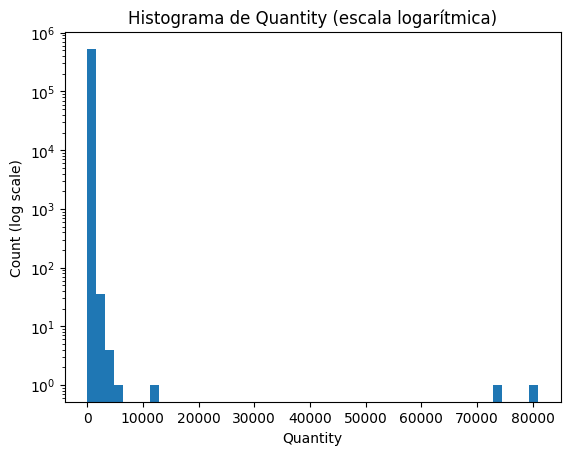

In [311]:
plt.hist(df['Quantity'], bins=50, log=True)
plt.xlabel('Quantity')
plt.ylabel('Count (log scale)')
plt.title('Histograma de Quantity (escala logarítmica)')
plt.show()

I see a couple of outliers

In [312]:
df.query('Quantity>70000') #these outliers distort my predictions

InvoiceNo StockCode                     Description  Quantity  \
InvoiceDate                                                                 
2023-01-18     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
2023-12-09     581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   

             UnitPrice  CustomerID         Country   Revenue  
InvoiceDate                                                   
2023-01-18        1.04     12346.0  United Kingdom   77183.6  
2023-12-09        2.08     16446.0  United Kingdom  168469.6

In [313]:
df=df[df['Quantity']<70000] # deleting since i doubt they have any predicting power

## Unit Price

In [314]:
df.UnitPrice.describe()

count    531283.000000
mean          3.857305
std          41.810126
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

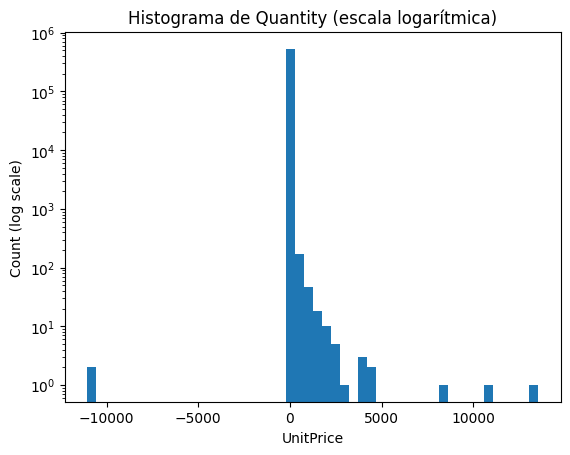

In [315]:
plt.hist(df['UnitPrice'], bins=50, log=True)
plt.xlabel('UnitPrice')
plt.ylabel('Count (log scale)')
plt.title('Histograma de Quantity (escala logarítmica)')
plt.show()

In [316]:
df=df[df['UnitPrice'] > 0] #deleting negative Qs dince analyzing revenue (and not benefits)

In [317]:
df.query('UnitPrice > 5000')

InvoiceNo  StockCode      Description  Quantity  UnitPrice  \
InvoiceDate                                                              
2022-12-07     537632  AMAZONFEE       AMAZON FEE         1   13541.33   
2023-05-03     551697       POST          POSTAGE         1    8142.75   
2023-08-12    A563185          B  Adjust bad debt         1   11062.06   

             CustomerID         Country   Revenue  
InvoiceDate                                        
2022-12-07          NaN  United Kingdom  13541.33  
2023-05-03      16029.0  United Kingdom   8142.75  
2023-08-12          NaN  United Kingdom  11062.06

In [318]:
df.query('Description == "AMAZON FEE"')

InvoiceNo  StockCode Description  Quantity  UnitPrice  CustomerID  \
InvoiceDate                                                                     
2022-12-07     537632  AMAZONFEE  AMAZON FEE         1   13541.33         NaN   
2023-03-28     547901  AMAZONFEE  AMAZON FEE         1     219.76         NaN   

                    Country   Revenue  
InvoiceDate                            
2022-12-07   United Kingdom  13541.33  
2023-03-28   United Kingdom    219.76

In [319]:
df.query('Description == "POSTAGE"')

InvoiceNo StockCode Description  Quantity  UnitPrice  CustomerID  \
InvoiceDate                                                                    
2022-12-01     536370      POST     POSTAGE         3       18.0     12583.0   
2022-12-01     536403      POST     POSTAGE         1       15.0     12791.0   
2022-12-01     536527      POST     POSTAGE         1       18.0     12662.0   
2022-12-02     536840      POST     POSTAGE         1       18.0     12738.0   
2022-12-03     536852      POST     POSTAGE         1       18.0     12686.0   
...               ...       ...         ...       ...        ...         ...   
2023-12-09     581493      POST     POSTAGE         1       15.0     12423.0   
2023-12-09     581494      POST     POSTAGE         2       18.0     12518.0   
2023-12-09     581570      POST     POSTAGE         1       18.0     12662.0   
2023-12-09     581574      POST     POSTAGE         2       18.0     12526.0   
2023-12-09     581578      POST     POSTAGE         3       18.0     12713.0   

                 Country  Revenue  
InvoiceDate                        
2022-12-01        France     54.0  
2022-12-01   Netherlands     15.0  
2022-12-01       Germany     18.0  
2022-12-02       Germany     18.0  
2022-12-03        France     18.0  
...                  ...      ...  
2023-12-09       Belgium     15.0  
2023-12-09       Germany     36.0  
2023-12-09       Germany     18.0  
2023-12-09       Germany     36.0  
2023-12-09       Germany     54.0  

[1126 rows x 8 columns]

In [320]:
df=df[df['UnitPrice'] < 5000] # deleting outliers since they're accounting adjustments, shipping (that, usually, are low cost), y amazon, since it doesnt seem to be usual

## Revenue

### Revenue Evolution

In [321]:
df_agrupado = df.groupby(df.index)['Revenue'].sum()

In [322]:
df_agrupado.describe()

count       305.000000
mean      34059.951489
std       18406.308661
min        3457.110000
25%       22088.320000
50%       29174.290000
75%       45254.730000
max      114419.890000
Name: Revenue, dtype: float64

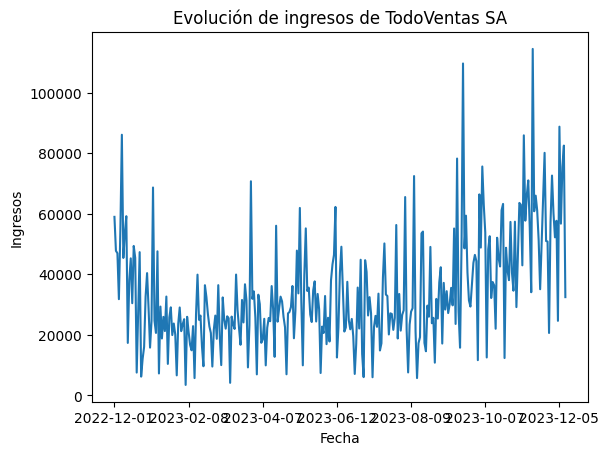

In [323]:
df_agrupado.plot(x='InvoiceDate',
                 y='revenue',
                 title="Evolución de ingresos de TodoVentas SA",
                 xlabel="Fecha",
                 ylabel="Ingresos",
                 legend=None);

We can observe an initial drop in revenue at the beginning of the period, remaining constant until September 2023, where we notice an upward trend.

### Revenue evolution by country (selecting top 5)

In [324]:
#grouping by date and country and adding each value
df_paises=df.groupby(['InvoiceDate','Country'])['Revenue'].sum().reset_index()

In [325]:
#now grouping by country, adding total revenue and taking the top 5 (index method)
paises_ordenados=df_paises.groupby('Country')['Revenue'].sum().sort_values(ascending=False).index
lista_top5=paises_ordenados[:5]

In [326]:
df_top5=df_paises[df_paises['Country'].isin(lista_top5)]

In [327]:
fig = px.line(df_top5, x='InvoiceDate', y='Revenue', color='Country',
              labels={'InvoiceDate': 'Fecha', 'Revenue': 'Ingresos', 'Country': 'País'},
              title='Evolución Temporal de los 5 Países con Mayores Ingresos')
fig.show()

In general, we can observe that the time series corresponding to the United Kingdom shows more variability than the rest of the countries, as well as higher revenues.

## Country

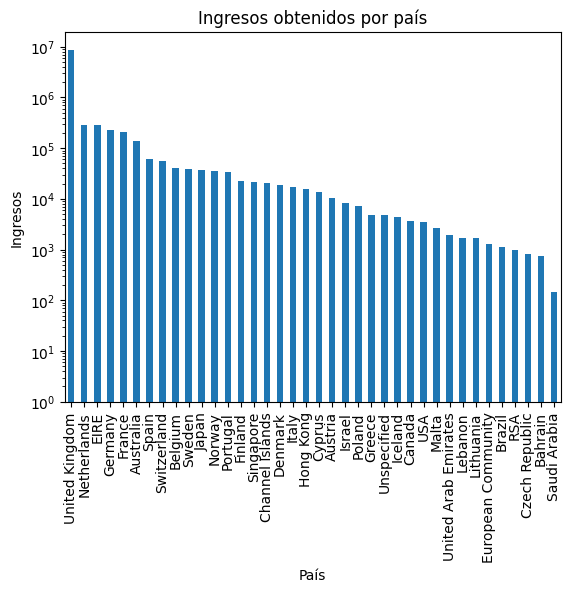

In [328]:
df_paises_ordenado = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False)
df_paises_ordenado.plot(x='Country',y='Revenue', kind='bar', xlabel='País',ylabel='Ingresos',title='Ingresos obtenidos por país', log=True);

We can see that the majority of revenue comes from UK 

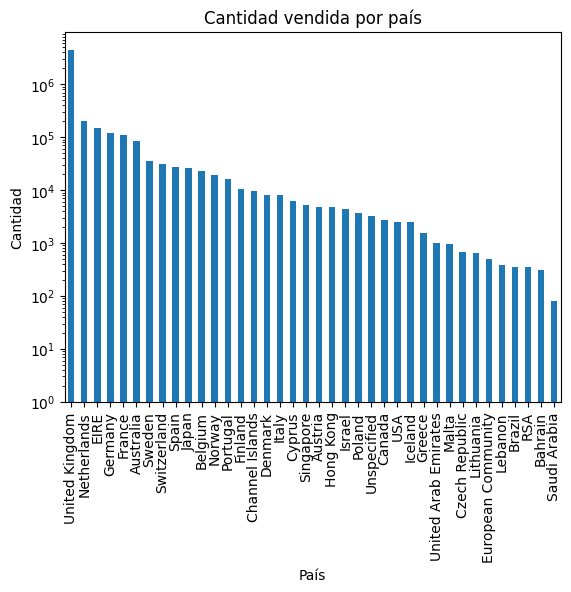

In [329]:
df_paises_ordenado2 = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False)
df_paises_ordenado2.plot(x='Country',y='Quantity', kind='bar',xlabel='País',ylabel='Cantidad', title='Cantidad vendida por país', log=True);

The United Kingdom is also the country where the most units are sold. I have used a logarithmic scale to better observe the distribution of revenues in the other countries.

## Products

In [330]:
# Creating a DataFrame that sums up the revenues by country, sorts them in ascending order, and puts the top 5 in a list.
productos_mas_vendidos=df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
productos_mayores_ingresos=df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

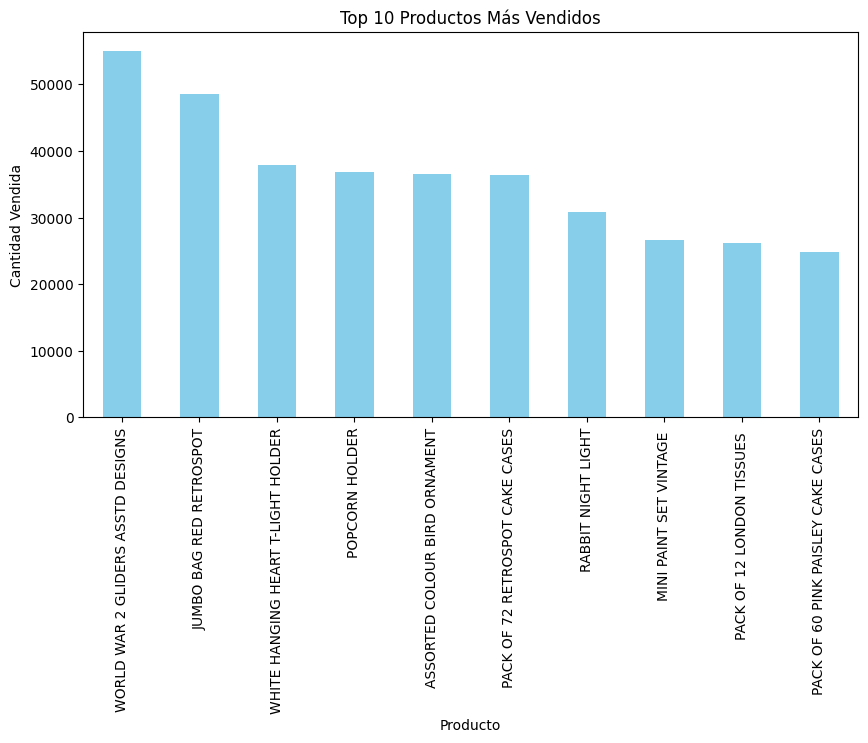

In [331]:
plt.figure(figsize=(10, 5))
productos_mas_vendidos.plot(kind='bar', color='skyblue')
plt.title('Top 10 Productos Más Vendidos')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.show()

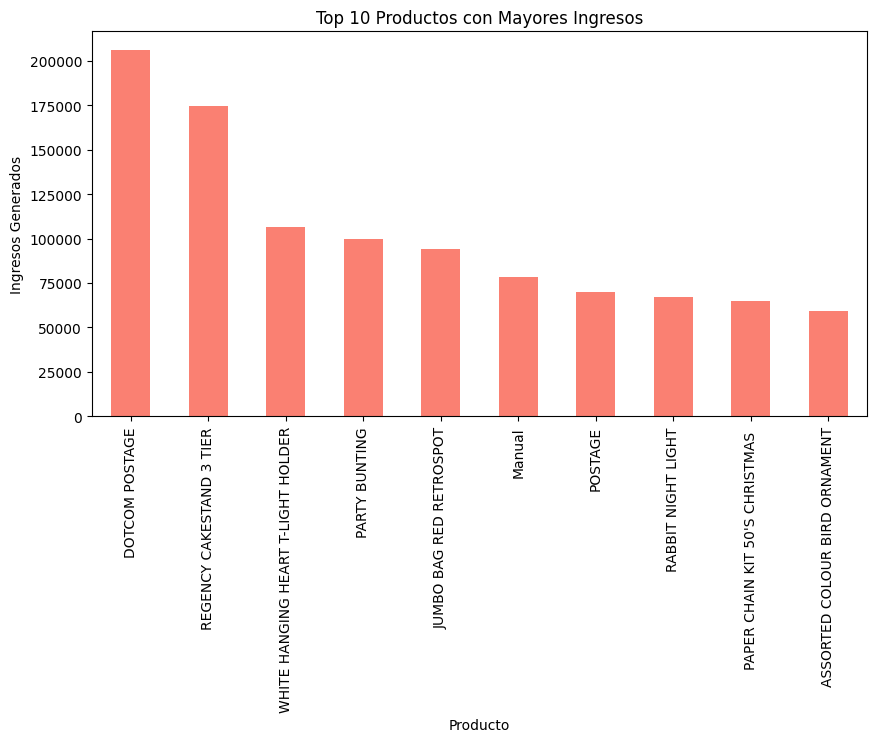

In [332]:
plt.figure(figsize=(10, 5))
productos_mayores_ingresos.plot(kind='bar', color='salmon')
plt.title('Top 10 Productos con Mayores Ingresos')
plt.xlabel('Producto')
plt.ylabel('Ingresos Generados')
plt.show()

In [333]:
#taking a look at the descriptions
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df.Description.value_counts())

WHITE HANGING HEART T-LIGHT HOLDER     2323
JUMBO BAG RED RETROSPOT                2112
REGENCY CAKESTAND 3 TIER               2017
PARTY BUNTING                          1706
LUNCH BAG RED RETROSPOT                1594
ASSORTED COLOUR BIRD ORNAMENT          1489
SET OF 3 CAKE TINS PANTRY DESIGN       1399
PACK OF 72 RETROSPOT CAKE CASES        1370
LUNCH BAG  BLACK SKULL.                1328
NATURAL SLATE HEART CHALKBOARD         1263
JUMBO BAG PINK POLKADOT                1238
HEART OF WICKER SMALL                  1226
PAPER CHAIN KIT 50'S CHRISTMAS         1200
JUMBO STORAGE BAG SUKI                 1197
JUMBO SHOPPER VINTAGE RED PAISLEY      1190
LUNCH BAG SPACEBOY DESIGN              1179
LUNCH BAG CARS BLUE                    1174
JAM MAKING SET PRINTED                 1169
SPOTTY BUNTING                         1158
JAM MAKING SET WITH JARS               1141
RECIPE BOX PANTRY YELLOW DESIGN        1126
POSTAGE                                1125
LUNCH BAG SUKI DESIGN           

In [334]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

### Monthly revenue

In [335]:
df.index = pd.to_datetime(df.index)
df['mes'] = df.index.month

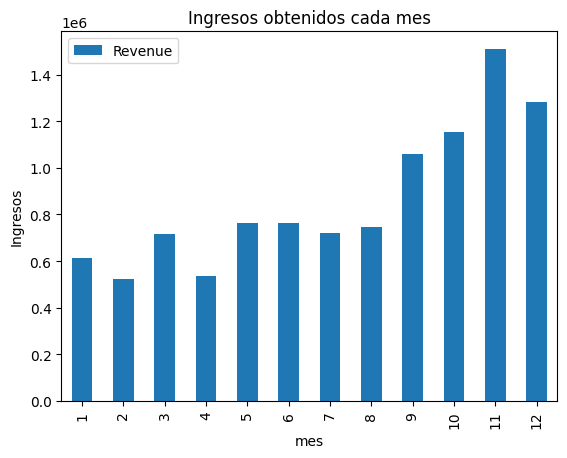

In [336]:
df_mensual=df.groupby('mes')['Revenue'].sum().reset_index()
df_mensual.plot(x='mes',y='Revenue', kind='bar', xlabel='mes',ylabel='Ingresos',title='Ingresos obtenidos cada mes');

We can see that the revenues increase at the end of the year, coinciding with Black Friday sales or the holiday season.

### Ingresos diarios

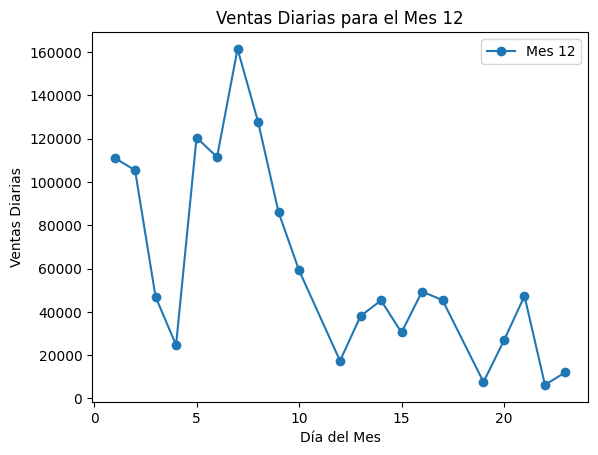

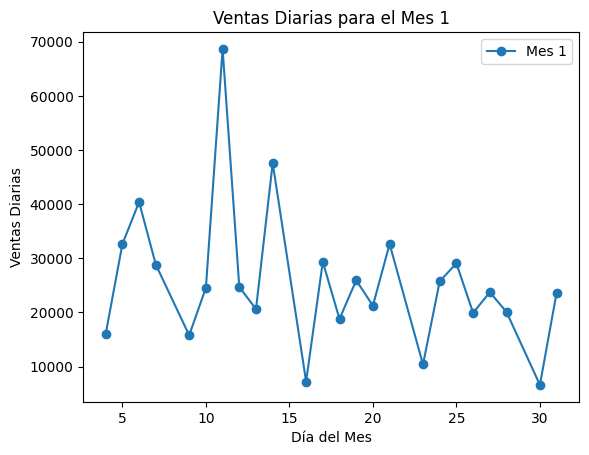

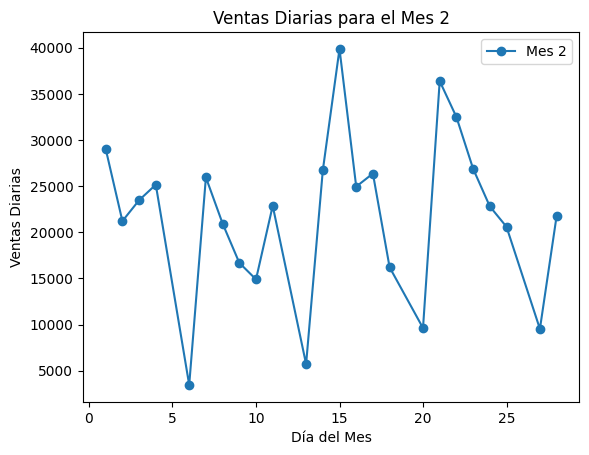

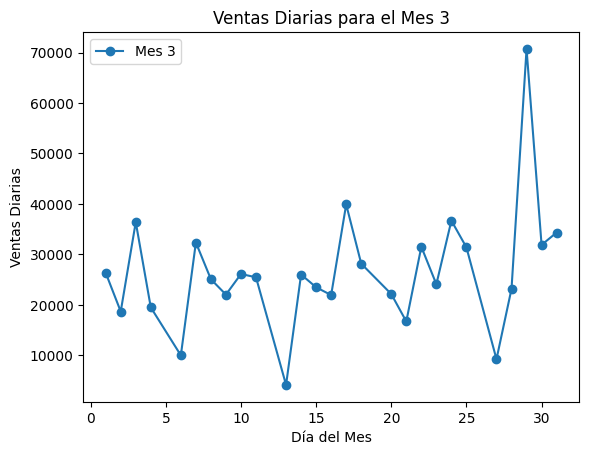

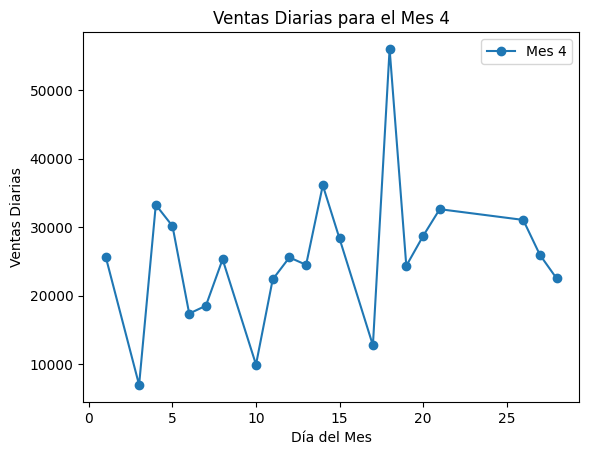

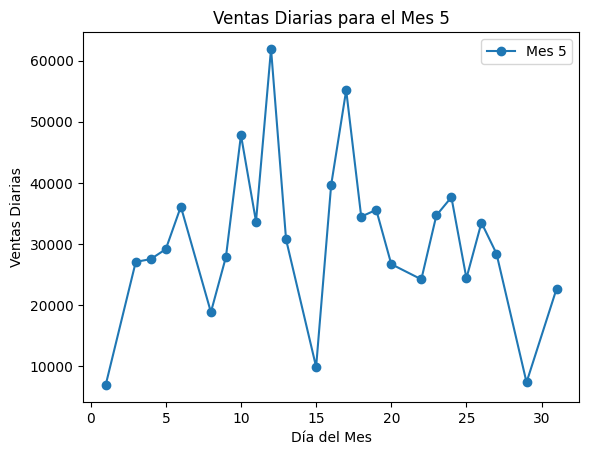

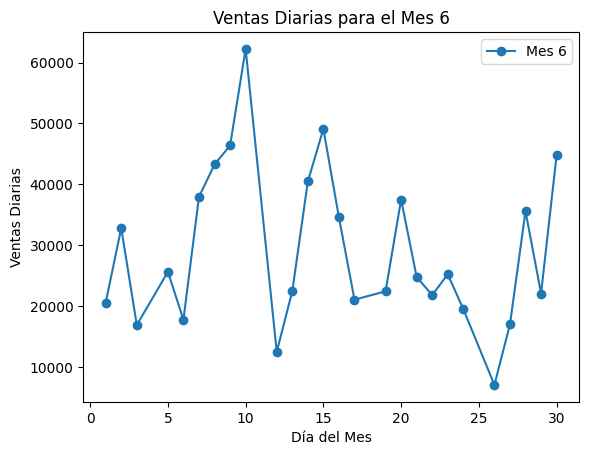

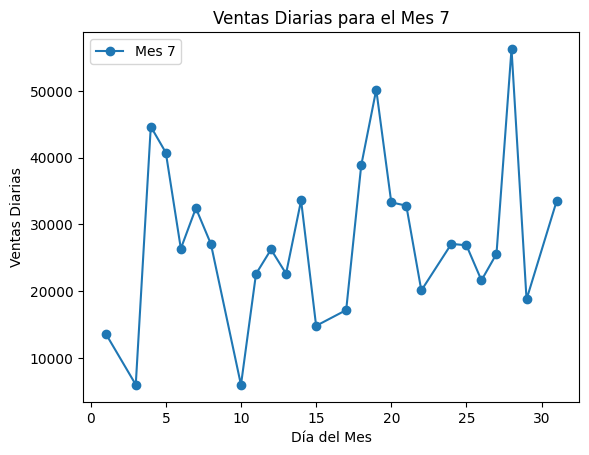

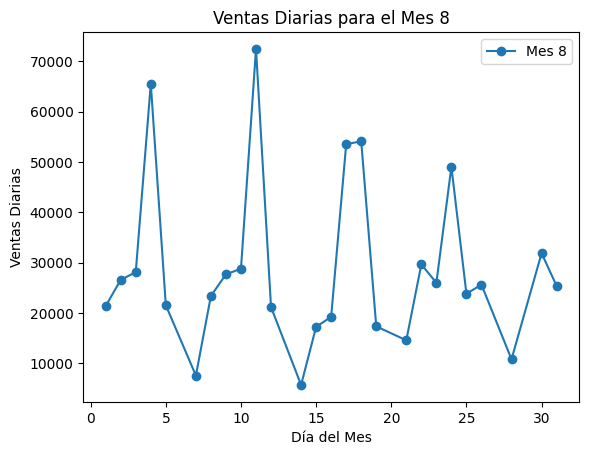

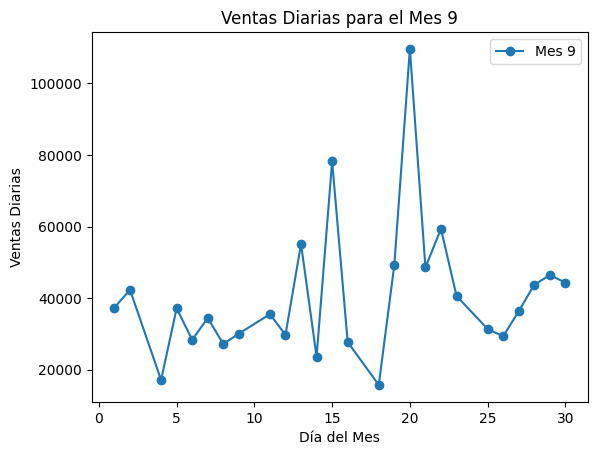

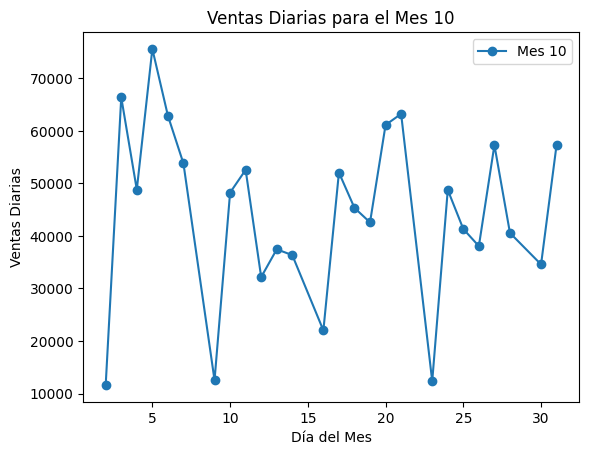

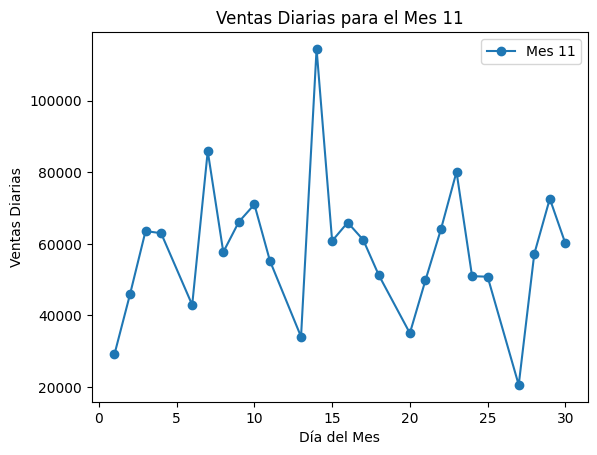

In [337]:
ventas_por_mes_y_dia = df.groupby([df.index.month, df.index.day])['Revenue'].sum()

# obtaining unique month list
meses_unicos = df.index.month.unique()

# Creating a graph for each month
for mes in meses_unicos:
    # filtering sales for actual month
    ventas_mes_actual = ventas_por_mes_y_dia[mes]

    plt.plot(ventas_mes_actual.index, ventas_mes_actual.values, marker='o', linestyle='-', label=f'Mes {mes}')

    plt.xlabel('Día del Mes')
    plt.ylabel('Ventas Diarias')
    plt.title(f'Ventas Diarias para el Mes {mes}')

    plt.legend()
    plt.show()

It is noteworthy that the majority of minimum monthly revenues occur on Mondays. This could be due to a lower propensity for consumption at the beginning of the workweek.

## Date

The variable 'date' presents an issue: there are no records for Sundays. When establishing the frequency of my data, there are two alternatives:
* Exclude Saturdays and set a daily frequency without including weekends.
* Include weekends by adding Sundays to the date and imputing values linearly.

To decide which of the two alternatives is better, lets take a look at the data and see if Saturdays are important in relation to revenue.

### Option 1

In [338]:
df.head()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                            
2022-12-01     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2022-12-01     536365     71053                  WHITE METAL LANTERN   
2022-12-01     536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2022-12-01     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2022-12-01     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

             Quantity  UnitPrice  CustomerID         Country  Revenue  mes  
InvoiceDate                                                                 
2022-12-01          6       2.55     17850.0  United Kingdom    15.30   12  
2022-12-01          6       3.39     17850.0  United Kingdom    20.34   12  
2022-12-01          8       2.75     17850.0  United Kingdom    22.00   12  
2022-12-01          6       3.39     17850.0  United Kingdom    20.34   12  
2022-12-01          6       3.39     17850.0  United Kingdom    20.34   12

In [339]:
df.index = pd.to_datetime(df.index)
df['Day_of_Week'] = df.index.day_name()

In [340]:
df.head()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                            
2022-12-01     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2022-12-01     536365     71053                  WHITE METAL LANTERN   
2022-12-01     536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2022-12-01     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2022-12-01     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

             Quantity  UnitPrice  CustomerID         Country  Revenue  mes  \
InvoiceDate                                                                  
2022-12-01          6       2.55     17850.0  United Kingdom    15.30   12   
2022-12-01          6       3.39     17850.0  United Kingdom    20.34   12   
2022-12-01          8       2.75     17850.0  United Kingdom    22.00   12   
2022-12-01          6       3.39     17850.0  United Kingdom    20.34   12   
2022-12-01          6       3.39     17850.0  United Kingdom    20.34   12   

            Day_of_Week  
InvoiceDate              
2022-12-01     Thursday  
2022-12-01     Thursday  
2022-12-01     Thursday  
2022-12-01     Thursday  
2022-12-01     Thursday

In [341]:
df.tail()

InvoiceNo StockCode                      Description  Quantity  \
InvoiceDate                                                                  
2023-12-09     581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
2023-12-09     581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
2023-12-09     581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
2023-12-09     581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
2023-12-09     581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

             UnitPrice  CustomerID Country  Revenue  mes Day_of_Week  
InvoiceDate                                                           
2023-12-09        0.85     12680.0  France    10.20   12    Saturday  
2023-12-09        2.10     12680.0  France    12.60   12    Saturday  
2023-12-09        4.15     12680.0  France    16.60   12    Saturday  
2023-12-09        4.15     12680.0  France    16.60   12    Saturday  
2023-12-09        4.95     12680.0  France    14.85   12    Saturday

In [342]:
df.groupby('Day_of_Week')['Revenue'].sum().sort_values(ascending=False)

Day_of_Week
Friday       2203161.240
Wednesday    2079764.931
Thursday     1851147.810
Tuesday      1779575.041
Saturday     1660808.571
Monday        813827.611
Name: Revenue, dtype: float64

Given that it is the 4th highest revenue day of the week, I believe it might be detrimental to make predictions exclusively based on weekends. Therefore, I am going to create a series that includes Sundays and merge it with our DataFrame.

### Option 2

In [343]:
#creating a variable that includes my period of time + sundays and transforming it to a DataFrame
secuencia_domingos = pd.date_range(start='2022-12-01', end='2023-12-09', freq='D')
df_con_domingos=pd.DataFrame({'InvoiceDate': secuencia_domingos})

In [344]:
df = df.reset_index()

In [345]:
df.head()

InvoiceDate InvoiceNo StockCode                          Description  \
0  2022-12-01    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1  2022-12-01    536365     71053                  WHITE METAL LANTERN   
2  2022-12-01    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3  2022-12-01    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4  2022-12-01    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

   Quantity  UnitPrice  CustomerID         Country  Revenue  mes Day_of_Week  
0         6       2.55     17850.0  United Kingdom    15.30   12    Thursday  
1         6       3.39     17850.0  United Kingdom    20.34   12    Thursday  
2         8       2.75     17850.0  United Kingdom    22.00   12    Thursday  
3         6       3.39     17850.0  United Kingdom    20.34   12    Thursday  
4         6       3.39     17850.0  United Kingdom    20.34   12    Thursday

In [346]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_con_domingos['InvoiceDate'] = pd.to_datetime(df_con_domingos['InvoiceDate'])

# combining both dfs keeping all duplicate rows from the original df 
df = pd.merge(df_con_domingos, df, on='InvoiceDate', how='left')
df.set_index('InvoiceDate', inplace=True)

In [347]:
df.groupby(df.index)['Revenue'].sum()

InvoiceDate
2022-12-01    58960.79
2022-12-02    47748.38
2022-12-03    46943.71
2022-12-04        0.00
2022-12-05    31774.95
                ...   
2023-12-05    88741.96
2023-12-06    56713.21
2023-12-07    75439.16
2023-12-08    82495.00
2023-12-09    32451.00
Name: Revenue, Length: 374, dtype: float64

In [348]:
df['Day_of_Week'] = df.index.day_name()

In [349]:
df.query('Day_of_Week=="Sunday"')

InvoiceNo StockCode Description  Quantity  UnitPrice  CustomerID  \
InvoiceDate                                                                    
2022-12-04        NaN       NaN         NaN       NaN        NaN         NaN   
2022-12-11        NaN       NaN         NaN       NaN        NaN         NaN   
2022-12-18        NaN       NaN         NaN       NaN        NaN         NaN   
2022-12-25        NaN       NaN         NaN       NaN        NaN         NaN   
2023-01-01        NaN       NaN         NaN       NaN        NaN         NaN   
2023-01-08        NaN       NaN         NaN       NaN        NaN         NaN   
2023-01-15        NaN       NaN         NaN       NaN        NaN         NaN   
2023-01-22        NaN       NaN         NaN       NaN        NaN         NaN   
2023-01-29        NaN       NaN         NaN       NaN        NaN         NaN   
2023-02-05        NaN       NaN         NaN       NaN        NaN         NaN   
2023-02-12        NaN       NaN         NaN       NaN        NaN         NaN   
2023-02-19        NaN       NaN         NaN       NaN        NaN         NaN   
2023-02-26        NaN       NaN         NaN       NaN        NaN         NaN   
2023-03-05        NaN       NaN         NaN       NaN        NaN         NaN   
2023-03-12        NaN       NaN         NaN       NaN        NaN         NaN   
2023-03-19        NaN       NaN         NaN       NaN        NaN         NaN   
2023-03-26        NaN       NaN         NaN       NaN        NaN         NaN   
2023-04-02        NaN       NaN         NaN       NaN        NaN         NaN   
2023-04-09        NaN       NaN         NaN       NaN        NaN         NaN   
2023-04-16        NaN       NaN         NaN       NaN        NaN         NaN   
2023-04-23        NaN       NaN         NaN       NaN        NaN         NaN   
2023-04-30        NaN       NaN         NaN       NaN        NaN         NaN   
2023-05-07        NaN       NaN         NaN       NaN        NaN         NaN   
2023-05-14        NaN       NaN         NaN       NaN        NaN         NaN   
2023-05-21        NaN       NaN         NaN       NaN        NaN         NaN   
2023-05-28        NaN       NaN         NaN       NaN        NaN         NaN   
2023-06-04        NaN       NaN         NaN       NaN        NaN         NaN   
2023-06-11        NaN       NaN         NaN       NaN        NaN         NaN   
2023-06-18        NaN       NaN         NaN       NaN        NaN         NaN   
2023-06-25        NaN       NaN         NaN       NaN        NaN         NaN   
2023-07-02        NaN       NaN         NaN       NaN        NaN         NaN   
2023-07-09        NaN       NaN         NaN       NaN        NaN         NaN   
2023-07-16        NaN       NaN         NaN       NaN        NaN         NaN   
2023-07-23        NaN       NaN         NaN       NaN        NaN         NaN   
2023-07-30        NaN       NaN         NaN       NaN        NaN         NaN   
2023-08-06        NaN       NaN         NaN       NaN        NaN         NaN   
2023-08-13        NaN       NaN         NaN       NaN        NaN         NaN   
2023-08-20        NaN       NaN         NaN       NaN        NaN         NaN   
2023-08-27        NaN       NaN         NaN       NaN        NaN         NaN   
2023-09-03        NaN       NaN         NaN       NaN        NaN         NaN   
2023-09-10        NaN       NaN         NaN       NaN        NaN         NaN   
2023-09-17        NaN       NaN         NaN       NaN        NaN         NaN   
2023-09-24        NaN       NaN         NaN       NaN        NaN         NaN   
2023-10-01        NaN       NaN         NaN       NaN        NaN         NaN   
2023-10-08        NaN       NaN         NaN       NaN        NaN         NaN   
2023-10-15        NaN       NaN         NaN       NaN        NaN         NaN   
2023-10-22        NaN       NaN         NaN       NaN        NaN         NaN   
2023-10-29        NaN       NaN         NaN       NaN        NaN         NaN   
2023-11-05  

In [350]:
relleno_nans = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

# filtering where 'Day_of_Week' is "Sunday"
domingos = df[df['Day_of_Week'] == 'Sunday']

# Imputing nulls 
domingos.loc[:, relleno_nans] = domingos[relleno_nans].fillna({'InvoiceNo': 999999, 'StockCode': 999999, 'Description': 'Unknown', 'CustomerID': 'Unknown', 'Country': 'Unknown'})
df.update(domingos)

<ipython-input-350-b481ca30489d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-350-b481ca30489d>:8: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [351]:
df.InvoiceNo.isna().sum()

16

he presence of 16 null values that are not Sundays is because my original dataset does not include these days. My reasoning is that, being holidays/vacation periods, the company was closed for the holiday season. 

Since the rest of the variables do not provide information for the analysis I want to perform (time series analysis of Revenue), I will not impute them. The only imputation I will make is for Revenue.

In [352]:
print(df[df['InvoiceNo'].isna()])

            InvoiceNo StockCode Description  Quantity  UnitPrice CustomerID  \
InvoiceDate                                                                   
2022-12-24        NaN       NaN         NaN       NaN        NaN        NaN   
2022-12-26        NaN       NaN         NaN       NaN        NaN        NaN   
2022-12-27        NaN       NaN         NaN       NaN        NaN        NaN   
2022-12-28        NaN       NaN         NaN       NaN        NaN        NaN   
2022-12-29        NaN       NaN         NaN       NaN        NaN        NaN   
2022-12-30        NaN       NaN         NaN       NaN        NaN        NaN   
2022-12-31        NaN       NaN         NaN       NaN        NaN        NaN   
2023-01-02        NaN       NaN         NaN       NaN        NaN        NaN   
2023-01-03        NaN       NaN         NaN       NaN        NaN        NaN   
2023-04-22        NaN       NaN         NaN       NaN        NaN        NaN   
2023-04-24        NaN       NaN         NaN       Na

# Nulls

In [353]:
df_agrupado = df.groupby(df.index)['Revenue'].sum()
df_agrupado = pd.DataFrame({'Revenue': df_agrupado})

When grouping values (by sum), the NaNs become 0. It is necessary to take this into account when filling it.

In [354]:
df_agrupado['Revenue'].isna().sum()

0

In [355]:
df_agrupado['Revenue'] = np.where(df_agrupado['Revenue'] == 0, np.nan, df_agrupado['Revenue'])


In [356]:
df_agrupado['Revenue'].interpolate(inplace=True)

In [357]:
# Obtén el primer y último valor del índice
primer_valor = df_agrupado.index.min()
ultimo_valor = df_agrupado.index.max()

# Muestra los resultados
print(f"Primer valor del índice: {primer_valor}")
print(f"Último valor del índice: {ultimo_valor}")

Primer valor del índice: 2022-12-01 00:00:00
Último valor del índice: 2023-12-09 00:00:00


In [358]:
#mkaing sure there are no any missing dates:

df_agrupado.index = pd.to_datetime(df_agrupado.index)

rango_fechas_esperadas = pd.date_range(start=df_agrupado.index.min(), end=df_agrupado.index.max(), freq='D')

# verifying
fechas_faltantes = rango_fechas_esperadas[~rango_fechas_esperadas.isin(df_agrupado.index)]

print("Fechas faltantes en el índice:")
print(fechas_faltantes)


Fechas faltantes en el índice:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [359]:
frecuencia_inferida = pd.infer_freq(df_agrupado.index)
print(f"Frecuencia inferida: {frecuencia_inferida}")

Frecuencia inferida: D


# Business Conclusions

The exploratory analysis allows us to draw the following conclusions:
* The majority of revenue is generated by selling in small quantities.
* Most sales and revenue come from the United Kingdom (it would be advisable to focus marketing and advertising policies on the English population, analyze local consumption patterns, etc.).
* At the beginning of the studied period (December 2022-February 2023), revenues showed a downward trend and remained at that level until September 2023, where they began to decrease. Most discounts occurred in March, but it does not seem that they had a positive impact on sales since they did not increase (although in March, they stopped decreasing, indicating a possible containment measure).
* In September 2023, revenues began to increase, a trend that has continued until the end of the studied period.
* The best-selling products are shown in the section above.
* November was the month with the highest revenues, while February and March were the lowest.
* In general, Monday is the day of the week with the lowest revenue production.

# **PART II. Time Series Analysis of Revenue**

# 1. ARIMA Models

I am going to start analyzing the time series corresponding to revenues in isolation.

In [360]:
df_agrupado.Revenue.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Series name: Revenue
Non-Null Count  Dtype  
--------------  -----  
374 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [361]:
px.line(df_agrupado, title='Evolución temporal de los ingresos')

In [362]:
df_agrupado.head()

Revenue
InvoiceDate          
2022-12-01   58960.79
2022-12-02   47748.38
2022-12-03   46943.71
2022-12-04   39359.33
2022-12-05   31774.95

## Time series decomposition

I am going to use the multiplicative model to decompose the time series because it seems that as the level of the time series increases, the variation also increases.

In [363]:
df_agrupado.index = pd.to_datetime(df_agrupado.index)

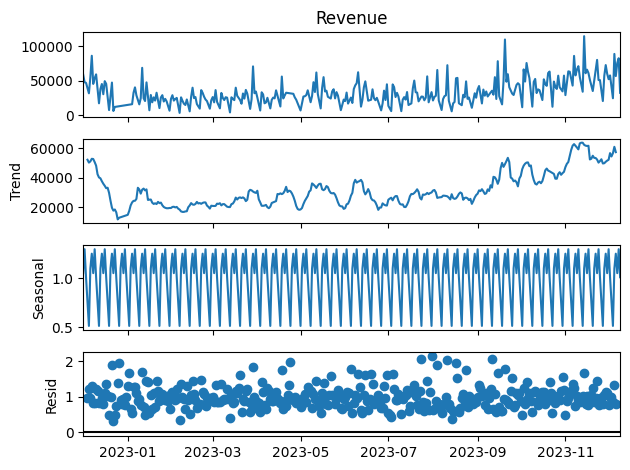

In [364]:
result = seasonal_decompose(df_agrupado['Revenue'], model='multiplicative')
result.plot()
plt.show()

Analyzing the time series, we can observe a decreasing trend at the beginning of the period, remaining relatively constant from January to August 2023, and increasing from that date until the end of the period.

## Autocorrelation and partial autocorrelation

In [365]:
 df_corr = df_agrupado['Revenue'].autocorr()
 df_corr

0.4870344754908575

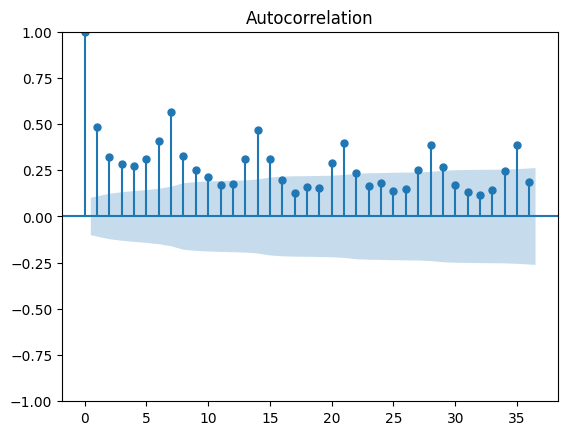

In [366]:
plot_acf(df_agrupado['Revenue'], lags = 36)
plt.show()

This graph suggests that my series is non stationary, and that there is seasonality in my data (probs weekly).

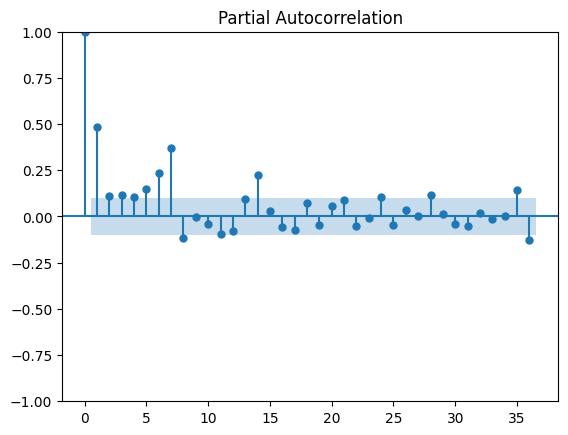

In [367]:
plot_pacf(df_agrupado['Revenue'], lags = 36)
plt.show()

## Stationarity

Using DF Test, we can see a high p value, therefore we do not have enough evidence to reject the null hypothesis (the time series has unit root and therefore is not stationary).

In [368]:
result_adf_pass = adfuller(df_agrupado['Revenue'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result_adf_pass))

{'adf': -1.6073312573152425,
 'pvalue': 0.479909810355127,
 'usedlag': 13,
 'nobs': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7757.383522927183}

Taking 1st difference to correct it

In [369]:
df_agrupado['diferencias'] = df_agrupado['Revenue'] - df_agrupado['Revenue'].shift(1)
df_agrupado.head()

Revenue  diferencias
InvoiceDate                       
2022-12-01   58960.79          NaN
2022-12-02   47748.38    -11212.41
2022-12-03   46943.71      -804.67
2022-12-04   39359.33     -7584.38
2022-12-05   31774.95     -7584.38

In [370]:
px.line(df_agrupado['diferencias'], title='Primera diferencia de la serie temporal ingresos')

In [371]:
result_diff_pass = adfuller(df_agrupado['diferencias'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result_diff_pass))

{'adf': -8.446878073671051,
 'pvalue': 1.7033778155142579e-13,
 'usedlag': 12,
 'nobs': 360,
 'criticalvalues': {'1%': -3.448645946352023,
  '5%': -2.869602139060357,
  '10%': -2.5710650077160495},
 'icbest': 7735.69303403638}

After taking the first difference, the series has become stationary. Since we have a p-value less than 0.05, we can reject the null hypothesis and conclude that the time series has no unit root. Thus, a good estimate of the differencing coefficient (d) will be 1.

## Seasonality

The graphs suggest weekly seasonality, and so we need to correct it.

In [372]:
df_agrupado['dif_estacional']=df_agrupado['Revenue'] - df_agrupado['Revenue'].shift(7)

In [373]:
resultado_est = adfuller((df_agrupado['dif_estacional']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], resultado_est))

{'adf': -6.618769504510802,
 'pvalue': 6.111797038122901e-09,
 'usedlag': 16,
 'nobs': 350,
 'criticalvalues': {'1%': -3.4491725955218655,
  '5%': -2.8698334971428574,
  '10%': -2.5711883591836733},
 'icbest': 7615.866508769729}

Since the p value is less than 0.05, we reject the null hypothesis of non seasonality (we'll use 0 as D value).

## Autocorrelation test

In [374]:
df_agrupado.head()

Revenue  diferencias  dif_estacional
InvoiceDate                                       
2022-12-01   58960.79          NaN             NaN
2022-12-02   47748.38    -11212.41             NaN
2022-12-03   46943.71      -804.67             NaN
2022-12-04   39359.33     -7584.38             NaN
2022-12-05   31774.95     -7584.38             NaN

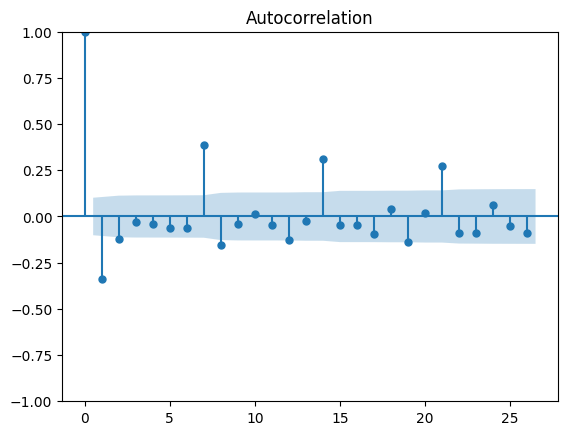

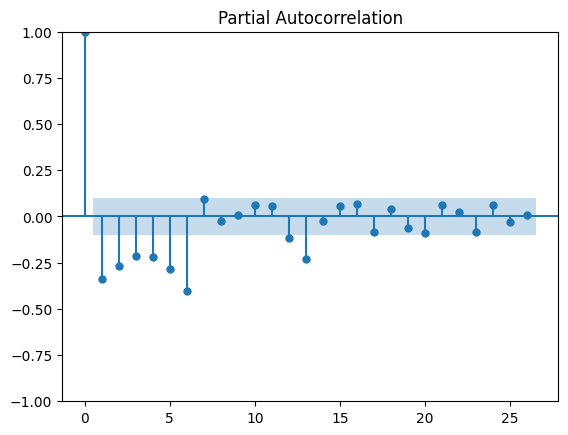

In [375]:
acf = plot_acf(df_agrupado['diferencias'].dropna())
pacf = plot_pacf(df_agrupado['diferencias'].dropna())

Since there are significant lags in both plots, it is likely that both autoregressive (AR) and moving average (MA) components need to be considered.

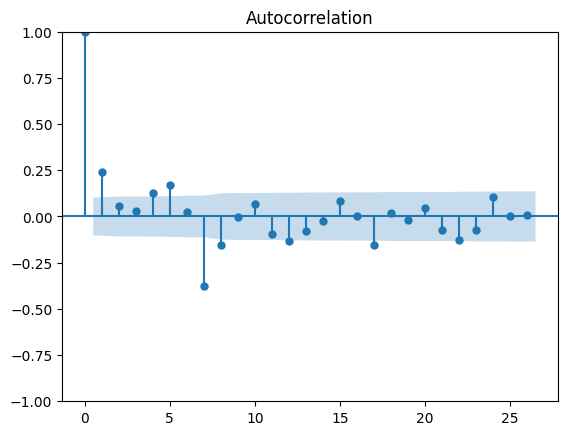

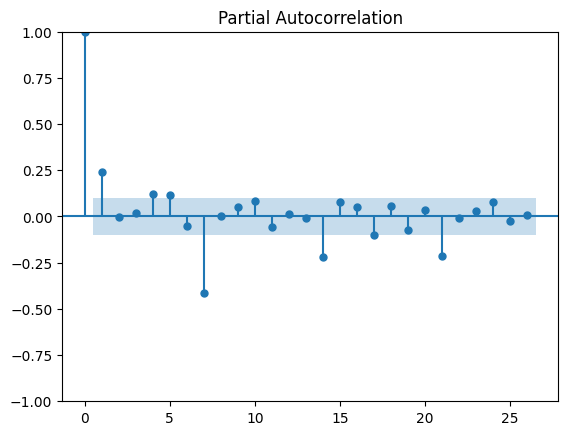

In [376]:
seas_acf = plot_acf(df_agrupado['dif_estacional'].dropna())
seas_pacf = plot_pacf(df_agrupado['dif_estacional'].dropna())

In [377]:
px.line(df_agrupado, title='Revenue y sus diferencias')

## Adjusting the model

### Initial ARIMA model

In [378]:
model = SARIMAX(df_agrupado['Revenue'],order=(1,2,1), seasonal_order=(1, 0, 0, 7))
result = model.fit()
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  374
Model:             SARIMAX(1, 2, 1)x(1, 0, [], 7)   Log Likelihood               -4142.701
Date:                            Sat, 03 Feb 2024   AIC                           8293.402
Time:                                    13:06:49   BIC                           8309.077
Sample:                                12-01-2022   HQIC                          8299.627
                                     - 12-09-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3542      0.064     -5.541      0.000      -0.479      -0.229
ma.L1         -0.9964      0.075    -13.343      0.000      -1.143      -0.850
ar.S.L7        0.4094      0.065      6.337      0.000       0.283       0.536
sigma2      4.099e+08   1.33e-10   3.09e+18      0.000     4.1e+08     4.1e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.04   Jarque-Bera (JB):                75.42
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.5e+33. Standard errors may be unstable.
"""

Based on the results obtained from the SARIMAX model, several significant relationships can be observed. Firstly, the ar.L1 coefficient of -0.3542 indicates a negative relationship between current revenues and previous revenues. This is supported by a p-value of 0.000, indicating high statistical significance.

Additionally, the ma.L1 coefficient of -0.9964 points to a negative relationship with the error of the previous observation, suggesting a persistent influence of past errors. This coefficient is highly significant with a p-value of 0.000.

Regarding the seasonal component, the ar.S.L7 coefficient of 0.4094 reveals a positive relationship in the seventh period of the seasonal cycle, and this coefficient is highly significant with a p-value of 0.000.

This initial model will be compared with an autoarima later.

#### Diagnosis

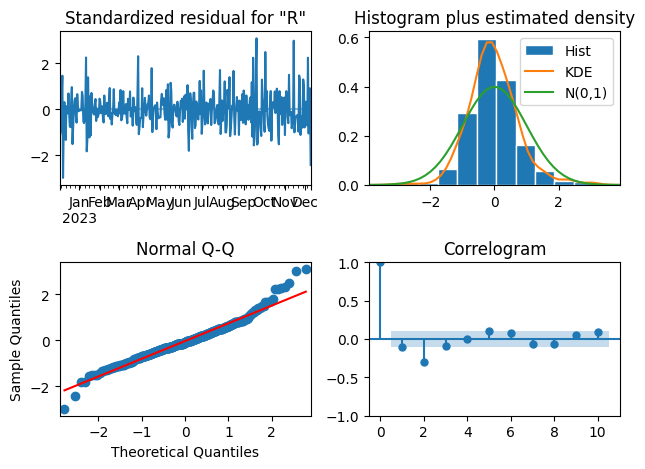

In [379]:
result.plot_diagnostics()
plt.tight_layout()
plt.show()

#### Prediction

In [380]:
display(df_agrupado.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Revenue         374 non-null    float64
 1   diferencias     373 non-null    float64
 2   dif_estacional  367 non-null    float64
dtypes: float64(3)
memory usage: 11.7 KB


None

In [381]:
new_dates_test = pd.date_range('2023-12-10', freq = 'D', periods=90)


df_pred = pd.DataFrame(pd.to_datetime(new_dates_test))
df_pred.columns = ['Month']
df_pred.set_index('Month', inplace = True)
df_pred['Revenue'] = np.nan
df_pred.rename_axis(None, inplace=True)
df_pred = df_pred.sort_index(ascending=True)
df_pred.index.freq = 'D'

In [382]:
df_now_after = pd.concat([df_agrupado,df_pred])
display(df_now_after.head(5))
display(df_now_after.tail(5))

Revenue  diferencias  dif_estacional
2022-12-01  58960.79          NaN             NaN
2022-12-02  47748.38    -11212.41             NaN
2022-12-03  46943.71      -804.67             NaN
2022-12-04  39359.33     -7584.38             NaN
2022-12-05  31774.95     -7584.38             NaN

Revenue  diferencias  dif_estacional
2024-03-04      NaN          NaN             NaN
2024-03-05      NaN          NaN             NaN
2024-03-06      NaN          NaN             NaN
2024-03-07      NaN          NaN             NaN
2024-03-08      NaN          NaN             NaN

<Axes: >

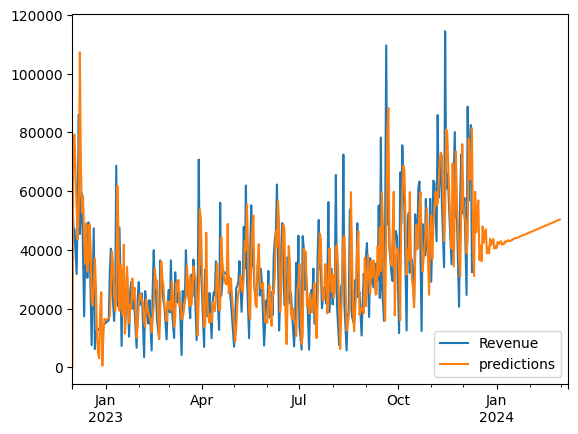

In [383]:
df_now_after['predictions'] = result.predict(start=0,end=455) # total months including out-sample
df_now_after[['Revenue','predictions']].plot()

This model does not seem to predict well our data, altough it adjusts quite well to the TS.

#### Evaluation

In [384]:
df_now_after_clean = df_now_after[~(df_now_after['diferencias'].isna()) & ~(df_now_after['predictions'].isna())]
mean_squared_error(df_now_after_clean['Revenue'], df_now_after_clean['predictions'], squared = False) # set false for RMSE

15778.62354667429

In [385]:
df_now_after_clean['Revenue'].mean()

31934.888900804286

### Autoarima Model

We are going to search for a model that better captures the time series, using a function that evaluates models of different orders (from 1 to 3 lags).

In [386]:
auto_arima_rev = auto_arima(df_agrupado['Revenue'],
                       start_P=0,
                       start_q=0,
                       max_p=3,
                       max_q=3,
                       m=7,
                       seasonal=True,
                       D=0,
                       max_d = 3,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=8258.299, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8367.059, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8266.958, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8201.966, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8365.066, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8229.595, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=8134.374, Time=3.13 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=8190.044, Time=0.41 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=8150.413, Time=4.79 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=8150.415, Time=5.13 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=8190.399, Time=1.11 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=8180.814, Time=0.84 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=5.18 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=8263.163, Time=1.88 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : 

It seems that the best model has the following characteristics:
- No autoregressive terms (p=0).
- The time series has been differenced once to make it stationary (d=1).
- There is a moving average term (q=1).

Regarding the seasonal component:
- There is a seasonal autoregressive term (P=1).
- No seasonal differencing (D=0).
- There is a seasonal moving average term (Q=1).
- The seasonal cycle repeats every 7 periods (s=7).

Differing from our initial model, we will compare the obtained metrics.

In [387]:
auto_arima_rev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  374
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4048.410
Date:                           Sat, 03 Feb 2024   AIC                           8104.820
Time:                                   13:08:07   BIC                           8120.506
Sample:                               12-01-2022   HQIC                          8111.049
                                    - 12-09-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8220      0.032    -25.614      0.000      -0.885      -0.759
ar.S.L7        0.9923      0.007    134.223      0.000       0.978       1.007
ma.S.L7       -0.9190      0.029    -31.897      0.000      -0.975      -0.863
sigma2       1.53e+08   4.63e-11    3.3e+18      0.000    1.53e+08    1.53e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):               351.00
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.78e+33. Standard errors may be unstable.
"""

The obtained values indicate that the coefficients are significant.

Based on the results, it seems that this model (SARIMAX(0, 1, 1)x(1, 0, 1, 7)) fits the data better than the previous model. This is because it has a higher Log Likelihood, indicating a better likelihood of the data according to the model. Additionally, lower AIC and BIC values suggest that this model is more efficient in terms of fit and complexity.

Both models pass some important tests, but Model 2 shows less heteroscedasticity and bias in the errors.

In [388]:
order = (0,1,1)
seasonal_order = (1, 0, 1, 7)

# Creating and adjusting the SARIMAX model
model_auto = SARIMAX(df_agrupado['Revenue'], order=order, seasonal_order=seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False)
results_auto_arima = model_auto.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [389]:
forecast_auto_arima = results_auto_arima.predict(start = len(df_agrupado),
                           end=len(df_agrupado)+90,
                           typ='levels').rename('forecast_auto_arima')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



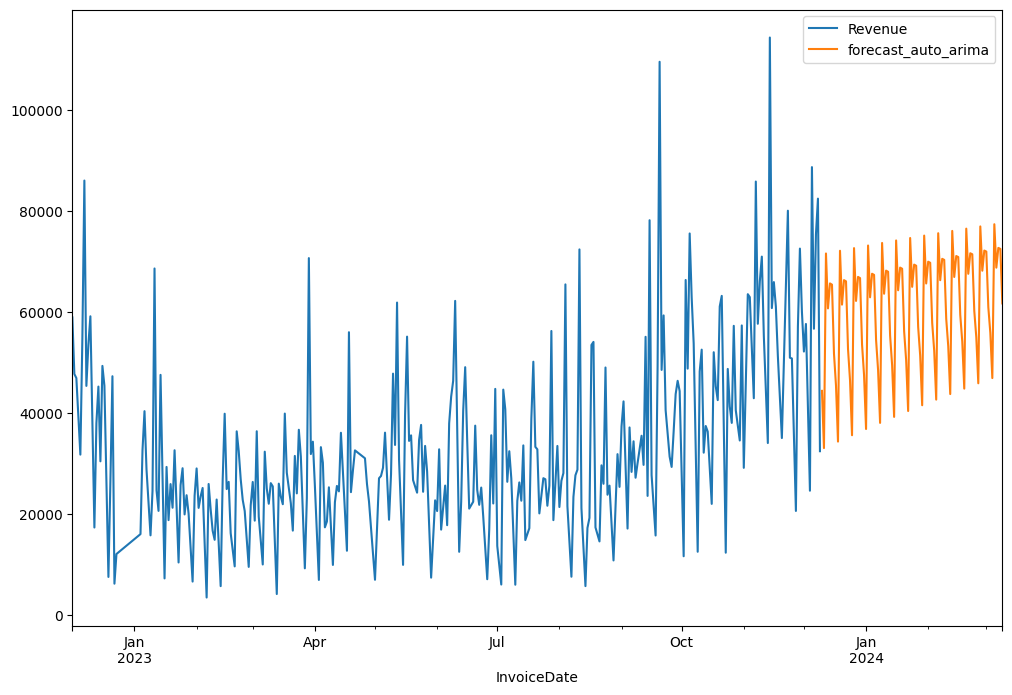

In [390]:
# Predicting out-of-sample
df_agrupado['Revenue'].plot(figsize=(12,8),legend=True)
forecast_auto_arima.plot(legend=True)
plt.show()

The obtained result does not seem very realistic, as it exhibits a pattern that is too regular. In any case, since this prediction has been made out of sample, we cannot evaluate it with error metrics.

#### Dividing in train & test

In [391]:
# Getting the index for the division (approximately 70%)
train_size = int(len(df_agrupado) * 0.7)

In [392]:
train_df = df_agrupado.iloc[:train_size]
test_df = df_agrupado.iloc[train_size:]

In [393]:
model_rev = SARIMAX(train_df['Revenue'],order=(0,1,1), seasonal_order=(1, 0, 1, 7))
result_rev = model_rev.fit()
result_rev.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           Revenue   No. Observations:                  261
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2792.492
Date:                           Sat, 03 Feb 2024   AIC                           5592.983
Time:                                   13:08:09   BIC                           5607.226
Sample:                               12-01-2022   HQIC                          5598.709
                                    - 08-18-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7484      0.039    -19.362      0.000      -0.824      -0.673
ar.S.L7        0.9884      0.013     78.314      0.000       0.964       1.013
ma.S.L7       -0.9057      0.046    -19.524      0.000      -0.997      -0.815
sigma2      1.215e+08   5.77e-11   2.11e+18      0.000    1.22e+08    1.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.54   Jarque-Bera (JB):               142.49
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             1.13
Prob(H) (two-sided):                  0.83   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.47e+32. Standard errors may be unstable.
"""

Comparing Model 2 (SARIMAX(0, 1, 1)x(1, 0, 1, 7)) with this new model, both show good fits to the data, but there are some notable differences.

Model 2 has a higher Log Likelihood, indicating a relatively better likelihood of the data according to the model. It also has lower values in AIC and BIC, suggesting better efficiency in terms of fit and complexity compared to the new model.

Both models pass important tests, but Model 2 seems to have less bias and heteroscedasticity in the errors. In summary, based on these evaluations, Model 2 remains preferable for modeling the time series.

#### Diagnostic

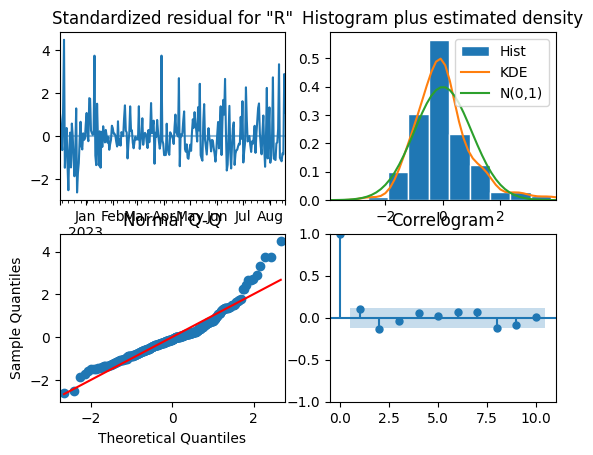

In [394]:
result_rev.plot_diagnostics()
plt.show()

#### Predictions

In [395]:
from pandas.tseries.offsets import DateOffset

new_dates = [train_df.index[-1] + DateOffset(days = x) for x in range(1, len(test_df))]


df_pred = pd.DataFrame(index = new_dates, columns = train_df.columns)

display(train_df.tail())
display(test_df.head())

Revenue  diferencias  dif_estacional
InvoiceDate                                       
2023-08-14    5718.57     -7725.36        -1860.34
2023-08-15   17243.97     11525.40        -6133.68
2023-08-16   19239.66      1995.69        -8439.78
2023-08-17   53499.96     34260.30        24707.62
2023-08-18   54106.93       606.97       -18326.86

Revenue  diferencias  dif_estacional
InvoiceDate                                        
2023-08-19   17349.590   -36757.340       -3819.700
2023-08-20   15963.225    -1386.365        2519.295
2023-08-21   14576.860    -1386.365        8858.290
2023-08-22   29651.460    15074.600       12407.490
2023-08-23   25993.680    -3657.780        6754.020

In [396]:
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
df_now_after = pd.concat([train_df,test_df])
display(df_now_after.head())
display(df_now_after.tail())

<ipython-input-396-8ff1d39117a9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-396-8ff1d39117a9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Revenue  diferencias  dif_estacional dataset
InvoiceDate                                               
2022-12-01   58960.79          NaN             NaN   train
2022-12-02   47748.38    -11212.41             NaN   train
2022-12-03   46943.71      -804.67             NaN   train
2022-12-04   39359.33     -7584.38             NaN   train
2022-12-05   31774.95     -7584.38             NaN   train

Revenue  diferencias  dif_estacional dataset
InvoiceDate                                               
2023-12-05   88741.96     64120.53        31576.77    test
2023-12-06   56713.21    -32028.75       -15882.72    test
2023-12-07   75439.16     18725.95        15312.20    test
2023-12-08   82495.00      7055.84        30297.75    test
2023-12-09   32451.00    -50044.00       -25213.07    test

In [397]:
df_now_after['predictions'] = result_rev.predict(start=0, end=len(train_df) + len(test_df))
px.line(df_now_after[['Revenue','predictions']])

The predictions seem to capture the general trend of the time series up to the moment of the validation set. It is necessary to consider that the trend of the time series starts to rise in August, just when our training sample ends. This explains a poorer prediction of future values if we do not take into account this part of the sample to train the model. 

#### Evaluation

In [398]:
test = df_now_after[df_now_after['dataset'] == 'test']

mse = mean_squared_error(test['Revenue'], test['predictions']) # set false for RMSE
rmse = mean_squared_error(test['Revenue'], test['predictions'], squared = False)
mae = mean_absolute_error(test['Revenue'], test['predictions']) # set false for RMSE

In [399]:
metrics_df = pd.DataFrame([mse, rmse, mae], index = ['mse', 'rmse', 'mae'])
metrics_df.columns = ['metrics']
metrics_df

metrics
mse   3.807258e+08
rmse  1.951220e+04
mae   1.438549e+04

In [400]:
new_dates = [df_now_after.index[-1] + DateOffset(days = x) for x in range(1, 91)]
df_pred = pd.DataFrame(index = new_dates, columns = df_now_after.columns)
df_pred.head()

df_new_after = pd.concat([df_now_after, df_pred])
df_new_after

Revenue  diferencias  dif_estacional dataset   predictions
2022-12-01  58960.79          NaN             NaN   train      0.000000
2022-12-02  47748.38    -11212.41             NaN   train  30791.552420
2022-12-03  46943.71      -804.67             NaN   train  37195.539152
2022-12-04  39359.33     -7584.38             NaN   train  40277.272833
2022-12-05  31774.95     -7584.38             NaN   train  40014.654107
...              ...          ...             ...     ...           ...
2024-03-04       NaN          NaN             NaN     NaN           NaN
2024-03-05       NaN          NaN             NaN     NaN           NaN
2024-03-06       NaN          NaN             NaN     NaN           NaN
2024-03-07       NaN          NaN             NaN     NaN           NaN
2024-03-08       NaN          NaN             NaN     NaN           NaN

[464 rows x 5 columns]

In [401]:
oos_period=89
df_new_after['predictions'] = result_rev.predict(start=0, end=len(train_df) + len(test_df) + oos_period)


In [402]:
df_new_after['Revenue'] = df_new_after['Revenue'].astype(float)
df_new_after

px.line(df_new_after[['Revenue','predictions']])

# 2. Prophet

## 2.1 Initial model

To use a Prophet model, I need my dataframe to have a specific format (the time series I want to predict should be named 'y', and I need to have a column with dates called ds).

In [403]:
pass_prophet = df_agrupado[['Revenue']]
pass_prophet = pass_prophet.rename(columns = {'Revenue':'y'})
pass_prophet['ds'] = pass_prophet.index
pass_prophet.reset_index(drop=True, inplace=False)
display(pass_prophet.head(2))

display(pass_prophet.info())

y         ds
InvoiceDate                     
2022-12-01   58960.79 2022-12-01
2022-12-02   47748.38 2022-12-02

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       374 non-null    float64       
 1   ds      374 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.8 KB


None

### Model instantiation + customization (holidays + sales) 

I have chosen to use the multiplicative model because this approach is appropriate when changes in the time series vary proportionally with the overall magnitude of the data (I do not observe constant variability).

In [404]:
# Model without special dates 
model_ml = Prophet(interval_width=0.9, weekly_seasonality=True)
model_ml.fit(pass_prophet)
future_ml_df = model_ml.make_future_dataframe(periods=90, freq='D')

# creating dfs for july and winter sales
inicio_julio = '2023-07-01'
fin_julio = '2023-07-15'
fechas_julio = pd.date_range(start=inicio_julio, end=fin_julio, freq='D')
df_fechas_julio = pd.DataFrame({'ds': fechas_julio})

inicio_invierno = '2023-01-06'
fin_invierno = '2023-01-15'
fechas_invierno = pd.date_range(start=inicio_invierno, end=fin_invierno, freq='D')
df_fechas_invierno = pd.DataFrame({'ds': fechas_invierno})

rebajas = pd.DataFrame({
    'holiday': 'Rebajas',
    'ds': df_fechas_julio['ds'].append(df_fechas_invierno['ds']),
    'lower_window': 0,
    'upper_window': 1,
})


#black friday
black_friday = pd.DataFrame({
    'holiday': 'BlackFriday',
    'ds': pd.to_datetime(['2023-11-24']),
    'lower_window': 0,
    'upper_window': 1,
})

# Adding all special dates to the model 
fechas_especiales = pd.concat((rebajas, black_friday))
m_mul = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, holidays=fechas_especiales).add_country_holidays(country_name='UK')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/ukxjyx1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/l70is2hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9942', 'data', 'file=/tmp/tmpxl9nxnpe/ukxjyx1u.json', 'init=/tmp/tmpxl9nxnpe/l70is2hl.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_modelbi9iks9z/prophet_model-20240203130810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-404-154ad525c784>:19: Futu

In [405]:
m_mul.fit(pass_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/q2padpqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/tzhbvcq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13293', 'data', 'file=/tmp/tmpxl9nxnpe/q2padpqb.json', 'init=/tmp/tmpxl9nxnpe/tzhbvcq7.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_model687jv0fi/prophet_model-20240203130810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Prediction

In [406]:
future_hols = m_mul.make_future_dataframe(periods=90, freq='D')
forecast_hols = m_mul.predict(future_hols)
forecast_hols

ds         trend    yhat_lower     yhat_upper   trend_lower  \
0   2022-12-01  29401.792614  16266.161269   47619.085634  29401.792614   
1   2022-12-02  29335.587364  22099.393618   53259.804107  29335.587364   
2   2022-12-03  29269.382113  13824.562127   45483.828799  29269.382113   
3   2022-12-04  29203.176863   7055.141306   37264.605990  29203.176863   
4   2022-12-05  29136.971613    427.110237   30880.375633  29136.971613   
..         ...           ...           ...            ...           ...   
459 2024-03-04  74837.832206  23614.074952   54632.580781  72495.827353   
460 2024-03-05  75054.530443  70038.981330  101733.570879  72663.336960   
461 2024-03-06  75271.228681  74583.306753  105183.145290  72845.633615   
462 2024-03-07  75487.926919  67069.912158   98612.579493  73013.442007   
463 2024-03-08  75704.625157  80411.548126  112912.647043  73188.192663   

      trend_upper  BlackFriday  BlackFriday_lower  BlackFriday_upper  \
0    29401.792614          0.0                0.0                0.0   
1    29335.587364          0.0                0.0                0.0   
2    29269.382113          0.0                0.0                0.0   
3    29203.176863          0.0                0.0                0.0   
4    29136.971613          0.0                0.0                0.0   
..            ...          ...                ...                ...   
459  77087.062747          0.0                0.0                0.0   
460  77338.316984          0.0                0.0                0.0   
461  77603.105674          0.0                0.0                0.0   
462  77861.245453          0.0                0.0                0.0   
463  78095.646783          0.0                0.0                0.0   

     Boxing Day  ...  multiplicative_terms  multiplicative_terms_lower  \
0           0.0  ...              0.094479                    0.094479   
1           0.0  ...              0.275997                    0.275997   
2           0.0  ...             -0.010024                   -0.010024   
3           0.0  ...             -0.235431                   -0.235431   
4           0.0  ...             -0.484356                   -0.484356   
..          ...  ...                   ...                         ...   
459         0.0  ...             -0.484356                   -0.484356   
460         0.0  ...              0.152674                    0.152674   
461         0.0  ...              0.206662                    0.206662   
462         0.0  ...              0.094479                    0.094479   
463         0.0  ...              0.275997                    0.275997   

     multiplicative_terms_upper    weekly  weekly_lower  weekly_upper  \
0                      0.094479  0.094479      0.094479      0.094479   
1                      0.275997  0.275997      0.275997      0.275997   
2                     -0.010024 -0.010024     -0.010024     -0.010024   
3                     -0.235431 -0.235431     -0.235431     -0.235431   
4                     -0.484356 -0.484356     -0.484356     -0.484356   
..                          ...       ...           ...           ...   
459                   -0.484356 -0.484356     -0.484356     -0.484356   
460                    0.152674  0.152674      0.152674      0.152674   
461                    0.206662  0.206662      0.206662      0.206662   
462                    0.094479  0.094479      0.094479      0.094479   
463                    0.275997  0.275997      0.275997      0.275997   

     additive_terms  additive_terms_lower  additive_terms_upper          yhat  
0               0.0                   0.0                   0.0  32179.644578  
1               0.0                   0.0                   0.0  37432.120498  
2               0.0                   0.0                   0.0  28975.988124  
3               0.0                   0.0                   0.0  22327.834548  
4               0.0                   0.0                   0.0  15024.295389  


In [407]:
plot_plotly(m_mul, forecast_hols)

In [408]:
plot_components_plotly(m_mul, forecast_hols)

### Validation

In [409]:
# Cross validation for both models 
cv_ml = cross_validation(model=model_ml, initial='100 days', period='30 days', horizon='90 days')
df_performance_ml = performance_metrics(cv_ml)

cv_mul = cross_validation(model=m_mul, initial='100 days', period='30 days', horizon='90 days')
df_performance_mul = performance_metrics(cv_mul)

INFO:prophet:Making 7 forecasts with cutoffs between 2023-03-14 00:00:00 and 2023-09-10 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/30nbjbxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/4mfwwjw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65763', 'data', 'file=/tmp/tmpxl9nxnpe/30nbjbxu.json', 'init=/tmp/tmpxl9nxnpe/4mfwwjw8.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_modeluwblezb7/prophet_model-20240203130811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/4b7wlf5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/bpfotr3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/g1797lap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/5g7wb8q4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80926', 'data', 'file=/tmp/tmpxl9nxnpe/g1797lap.json', 'init=/tmp/tmpxl9nxnpe/5g7wb8q4.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_model9jwk88u7/prophet_model-20240203130813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/2t3v3nbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/o_2iwcnh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [410]:
hols_performance = performance_metrics(cv_mul)

display(f'Modelo Prophet sin vacaciones ----------------------', df_performance_ml.describe().transpose())
display(f'Modelo Prophet con vacaciones ------------------- ', df_performance_mul.describe().transpose())

'Modelo Prophet sin vacaciones ----------------------'

count              mean                         std  \
horizon     82  49 days 12:00:00  23 days 19:33:58.568845364   
mse       82.0  286400516.293277            119265544.131992   
rmse      82.0      16574.209258                 3441.002779   
mae       82.0      12802.612296                 2696.410073   
mape      82.0          0.417342                    0.045909   
mdape     82.0          0.369368                    0.047182   
smape     82.0          0.454117                      0.0645   
coverage  82.0          0.757065                     0.10584   

                       min               25%               50%  \
horizon    9 days 00:00:00  29 days 06:00:00  49 days 12:00:00   
mse       124271793.780334  200553868.073615  247085694.825345   
rmse          11147.725947      14161.366899      15718.910528   
mae             9001.07198      10570.042101      12164.206039   
mape              0.337712          0.387772           0.41258   
mdape             0.273948          0.331616          0.376618   
smape              0.34792          0.397402          0.433073   
coverage          0.539683          0.650794          0.785714   

                       75%               max  
horizon   69 days 18:00:00  90 days 00:00:00  
mse       376942536.190006  562391007.479414  
rmse          19414.521012      23714.784576  
mae           15416.727786      18267.634248  
mape              0.435619           0.53941  
mdape             0.388685          0.469065  
smape             0.508862           0.58644  
coverage           0.84127          0.920635

'Modelo Prophet con vacaciones ------------------- '

count              mean                         std  \
horizon     82  49 days 12:00:00  23 days 19:33:58.568845364   
mse       82.0  255500217.130411             94113173.789911   
rmse      82.0      15730.400064                 2855.551098   
mae       82.0      11949.354049                 2321.639018   
mape      82.0          0.409328                    0.059551   
mdape     82.0          0.328308                    0.046786   
smape     82.0          0.372862                    0.044932   
coverage  82.0          0.646922                     0.08559   

                       min               25%               50%  \
horizon    9 days 00:00:00  29 days 06:00:00  49 days 12:00:00   
mse       129044012.772926  190211077.804904  224708498.807677   
rmse          11359.754081      13791.616091      14990.276484   
mae            8716.032673      10081.592365      11184.462068   
mape               0.30248          0.362187          0.407436   
mdape             0.244328          0.289282           0.32561   
smape             0.303846          0.338682          0.357529   
coverage           0.47619          0.603175          0.666667   

                       75%               max  
horizon   69 days 18:00:00  90 days 00:00:00  
mse       313556946.618095  469674293.440677  
rmse           17707.51761      21671.970225  
mae            13530.93795      17270.321917  
mape              0.460345          0.545364  
mdape             0.357226          0.449046  
smape              0.39873          0.483181  
coverage          0.714286          0.777778

The prophet model seems to adjust better to the data when we add sales periods. This makes sense since the TS reflects the sales revenue evolution.

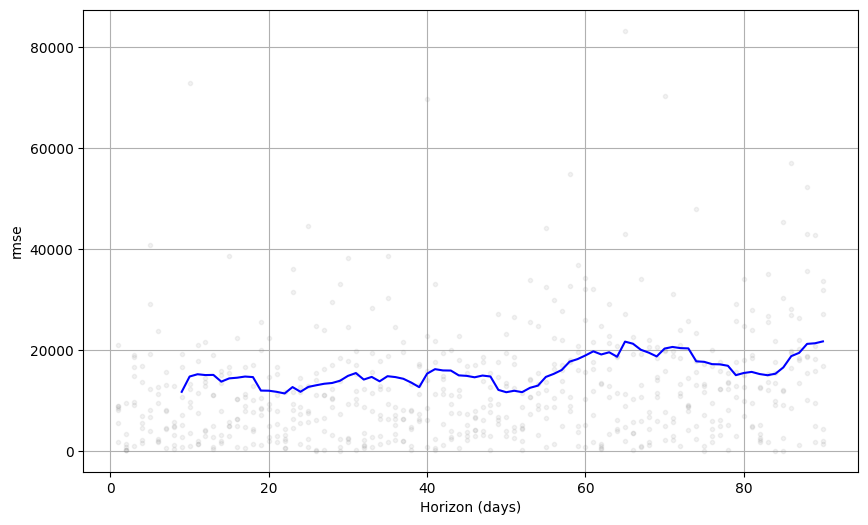

In [411]:
cv_plot_mul = plot_cross_validation_metric(cv_mul, metric = 'rmse')

In [412]:
df_performance_mul.describe().transpose()

count              mean                         std  \
horizon     82  49 days 12:00:00  23 days 19:33:58.568845364   
mse       82.0  255500217.130411             94113173.789911   
rmse      82.0      15730.400064                 2855.551098   
mae       82.0      11949.354049                 2321.639018   
mape      82.0          0.409328                    0.059551   
mdape     82.0          0.328308                    0.046786   
smape     82.0          0.372862                    0.044932   
coverage  82.0          0.646922                     0.08559   

                       min               25%               50%  \
horizon    9 days 00:00:00  29 days 06:00:00  49 days 12:00:00   
mse       129044012.772926  190211077.804904  224708498.807677   
rmse          11359.754081      13791.616091      14990.276484   
mae            8716.032673      10081.592365      11184.462068   
mape               0.30248          0.362187          0.407436   
mdape             0.244328          0.289282           0.32561   
smape             0.303846          0.338682          0.357529   
coverage           0.47619          0.603175          0.666667   

                       75%               max  
horizon   69 days 18:00:00  90 days 00:00:00  
mse       313556946.618095  469674293.440677  
rmse           17707.51761      21671.970225  
mae            13530.93795      17270.321917  
mape              0.460345          0.545364  
mdape             0.357226          0.449046  
smape              0.39873          0.483181  
coverage          0.714286          0.777778

Comparing these metrics with those of the second ARIMA model:
Comparing both:

MSE:
- Prophet: 2.54x10^8
- ARIMA: 3.81x10^8
Lower MSE in Prophet, suggesting a better fit.

RMSE:
- Prophet: 15698.02
- ARIMA: 19512.20
Lower RMSE in Prophet, indicating lower error in predictions.

MAE:
- Prophet: 11957.34
- ARIMA: 14385.49
Lower MAE in Prophet, suggesting a smaller magnitude of average error.

## 2.2. Train & test split

In [413]:
pass_prophet.sort_values(by='ds', inplace=True)
train_size = int(len(pass_prophet) * 0.7)
train_df = pass_prophet.iloc[:train_size]
test_df = pass_prophet.iloc[train_size:]


In [414]:
test_df.head()

y         ds
InvoiceDate                      
2023-08-19   17349.590 2023-08-19
2023-08-20   15963.225 2023-08-20
2023-08-21   14576.860 2023-08-21
2023-08-22   29651.460 2023-08-22
2023-08-23   25993.680 2023-08-23

### Instantiation of the model + customization (holidays+sales)

In [415]:
# Model without special dates
model_ml = Prophet(interval_width=0.9, weekly_seasonality=True)
model_ml.fit(train_df)
future_ml_df = model_ml.make_future_dataframe(periods=len(test_df)+90, freq='D')

# creating dfs for july and winter sales 
inicio_julio = '2023-07-01'
fin_julio = '2023-07-15'
fechas_julio = pd.date_range(start=inicio_julio, end=fin_julio, freq='D')
df_fechas_julio = pd.DataFrame({'ds': fechas_julio})

inicio_invierno = '2023-01-06'
fin_invierno = '2023-01-15'
fechas_invierno = pd.date_range(start=inicio_invierno, end=fin_invierno, freq='D')
df_fechas_invierno = pd.DataFrame({'ds': fechas_invierno})

rebajas = pd.DataFrame({
    'holiday': 'Rebajas',
    'ds': df_fechas_julio['ds'].append(df_fechas_invierno['ds']),
    'lower_window': 0,
    'upper_window': 1,
})


#black friday
black_friday = pd.DataFrame({
    'holiday': 'BlackFriday',
    'ds': pd.to_datetime(['2023-11-24']),
    'lower_window': 0,
    'upper_window': 1,
})

# adding all special dates to my model 
fechas_especiales = pd.concat((rebajas, black_friday))
m_mul = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, holidays=fechas_especiales).add_country_holidays(country_name='UK')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/jf729wmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/6oqlvg85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15489', 'data', 'file=/tmp/tmpxl9nxnpe/jf729wmn.json', 'init=/tmp/tmpxl9nxnpe/6oqlvg85.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_modeltxru3oac/prophet_model-20240203130815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-415-0d58ec77cbb3>:19: Fut

In [416]:
m_mul.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/oqy_9zv_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/pjc_pcue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82938', 'data', 'file=/tmp/tmpxl9nxnpe/oqy_9zv_.json', 'init=/tmp/tmpxl9nxnpe/pjc_pcue.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_modeleh027hs0/prophet_model-20240203130816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Prediction

In [417]:
future_hols = m_mul.make_future_dataframe(periods=len(test_df)+90, freq='D')
forecast_hols = m_mul.predict(future_hols)
forecast_hols

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2022-12-01  29217.071984  15853.509931  44445.861494  29217.071984   
1   2022-12-02  29157.216115  23648.292035  52118.623806  29157.216115   
2   2022-12-03  29097.360246  15572.530187  45067.422526  29097.360246   
3   2022-12-04  29037.504377   8396.627115  36788.254260  29037.504377   
4   2022-12-05  28977.648508    765.277107  28421.880200  28977.648508   
..         ...           ...           ...           ...           ...   
459 2024-03-04  32682.120289   2438.476883  31714.660467  29943.414750   
460 2024-03-05  32702.990573  19610.171889  47910.689050  29938.357412   
461 2024-03-06  32723.860857  27992.870946  57556.732766  29924.443930   
462 2024-03-07  32744.731141  20675.149053  48641.769983  29915.535432   
463 2024-03-08  32765.601426  29818.776785  58919.365155  29926.120531   

      trend_upper  BlackFriday  BlackFriday_lower  BlackFriday_upper  \
0    29217.071984          0.0                0.0                0.0   
1    29157.216115          0.0                0.0                0.0   
2    29097.360246          0.0                0.0                0.0   
3    29037.504377          0.0                0.0                0.0   
4    28977.648508          0.0                0.0                0.0   
..            ...          ...                ...                ...   
459  35608.328782          0.0                0.0                0.0   
460  35651.461457          0.0                0.0                0.0   
461  35682.328749          0.0                0.0                0.0   
462  35717.015810          0.0                0.0                0.0   
463  35763.634920          0.0                0.0                0.0   

     Boxing Day  ...  multiplicative_terms  multiplicative_terms_lower  \
0           0.0  ...              0.043721                    0.043721   
1           0.0  ...              0.325864                    0.325864   
2           0.0  ...              0.018514                    0.018514   
3           0.0  ...             -0.231692                   -0.231692   
4           0.0  ...             -0.483959                   -0.483959   
..          ...  ...                   ...                         ...   
459         0.0  ...             -0.483959                   -0.483959   
460         0.0  ...              0.038647                    0.038647   
461         0.0  ...              0.288905                    0.288905   
462         0.0  ...              0.043721                    0.043721   
463         0.0  ...              0.325864                    0.325864   

     multiplicative_terms_upper    weekly  weekly_lower  weekly_upper  \
0                      0.043721  0.043721      0.043721      0.043721   
1                      0.325864  0.325864      0.325864      0.325864   
2                      0.018514  0.018514      0.018514      0.018514   
3                     -0.231692 -0.231692     -0.231692     -0.231692   
4                     -0.483959 -0.483959     -0.483959     -0.483959   
..                          ...       ...           ...           ...   
459                   -0.483959 -0.483959     -0.483959     -0.483959   
460                    0.038647  0.038647      0.038647      0.038647   
461                    0.288905  0.288905      0.288905      0.288905   
462                    0.043721  0.043721      0.043721      0.043721   
463                    0.325864  0.325864      0.325864      0.325864   

     additive_terms  additive_terms_lower  additive_terms_upper          yhat  
0               0.0                   0.0                   0.0  30494.468667  
1               0.0                   0.0                   0.0  38658.501060  
2               0.0                   0.0                   0.0  29636.062785  
3               0.0                   0.0                   0.0  22309.751291  
4               0.0                   0.0                   0.0  14953.661691  
..          

In [418]:
plot_plotly(m_mul, forecast_hols)

In [419]:
plot_components_plotly(m_mul, forecast_hols)

### Validation

In [420]:
# Cross validation for both models
cv_ml = cross_validation(model=model_ml, initial='100 days', period='30 days', horizon='90 days')
df_performance_ml = performance_metrics(cv_ml)

cv_mul = cross_validation(model=m_mul, initial='100 days', period='30 days', horizon='90 days')
df_performance_mul = performance_metrics(cv_mul)

INFO:prophet:Making 3 forecasts with cutoffs between 2023-03-21 00:00:00 and 2023-05-20 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/2e3_lwfq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/s_ocryyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10783', 'data', 'file=/tmp/tmpxl9nxnpe/2e3_lwfq.json', 'init=/tmp/tmpxl9nxnpe/s_ocryyy.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_modelnaq4muxy/prophet_model-20240203130816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/wdbi66sz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/bf5l0m8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/da_gumwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/83v70zzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42688', 'data', 'file=/tmp/tmpxl9nxnpe/da_gumwy.json', 'init=/tmp/tmpxl9nxnpe/83v70zzx.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_modelfby3t8m7/prophet_model-20240203130818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/xgzmsyo5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/xb2tzfqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [421]:
hols_performance = performance_metrics(cv_mul)

display(f'Modelo Prophet sin vacaciones ----------------------', df_performance_ml.describe().transpose())
display(f'Modelo Prophet con vacaciones ------------------- ', df_performance_mul.describe().transpose())

'Modelo Prophet sin vacaciones ----------------------'

count              mean                         std              min  \
horizon     82  49 days 12:00:00  23 days 19:33:58.568845364  9 days 00:00:00   
mse       82.0   169179116.17568              75330554.13258  63669404.988146   
rmse      82.0      12711.423511                 2773.561103       7979.31106   
mae       82.0      10117.402103                 2339.465317      6325.626329   
mape      82.0          0.410794                    0.092342         0.263344   
mdape     82.0          0.361187                    0.087675         0.198482   
smape     82.0           0.41151                    0.083377         0.272473   
coverage  82.0          0.859079                    0.084023          0.62963   

                       25%               50%               75%  \
horizon   29 days 06:00:00  49 days 12:00:00  69 days 18:00:00   
mse        115826454.53607  144021664.444182  203178475.288312   
rmse          10762.251528      12000.887058      14254.068114   
mae            8465.364285       9289.577463      11491.985812   
mape              0.344494          0.401884          0.479505   
mdape             0.307683          0.334921           0.40951   
smape             0.344583          0.400053          0.462195   
coverage          0.787037          0.888889          0.925926   

                       max  
horizon   90 days 00:00:00  
mse       341452684.990244  
rmse          18478.438381  
mae           15077.861661  
mape              0.630663  
mdape             0.591718  
smape              0.59028  
coverage               1.0

'Modelo Prophet con vacaciones ------------------- '

count              mean                         std              min  \
horizon     82  49 days 12:00:00  23 days 19:33:58.568845364  9 days 00:00:00   
mse       82.0  179320667.268403             85506700.698847  62920721.807742   
rmse      82.0      13047.696814                  3031.55943      7932.258304   
mae       82.0      10488.212008                 3017.308611      6276.945093   
mape      82.0          0.473439                    0.173884          0.20724   
mdape     82.0          0.347317                    0.106927          0.15043   
smape     82.0           0.37888                      0.0929         0.231832   
coverage  82.0            0.6757                    0.169831         0.333333   

                       25%               50%               75%  \
horizon   29 days 06:00:00  49 days 12:00:00  69 days 18:00:00   
mse       120711161.438196  140109732.118064  223976427.117273   
rmse          10986.834463      11836.774173      14961.757786   
mae            8120.808062       9447.236911      12401.837347   
mape              0.326664           0.42368          0.643308   
mdape             0.250976          0.340032          0.416281   
smape             0.314682          0.350959           0.45294   
coverage          0.564815          0.722222          0.814815   

                       max  
horizon   90 days 00:00:00  
mse       375234950.893083  
rmse          19370.982187  
mae           16865.756011  
mape              0.796831  
mdape             0.600238  
smape             0.584458  
coverage          0.925926

In [422]:
cv_mul = cross_validation(model = m_mul,  initial='100 days', period='30 days', horizon = '90 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2023-03-21 00:00:00 and 2023-05-20 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/0_46pz1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/f5cpx8qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14660', 'data', 'file=/tmp/tmpxl9nxnpe/0_46pz1q.json', 'init=/tmp/tmpxl9nxnpe/f5cpx8qa.json', 'output', 'file=/tmp/tmpxl9nxnpe/prophet_modelapcyqw5v/prophet_model-20240203130820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/h_rdgj1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl9nxnpe/r_yxp5e2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

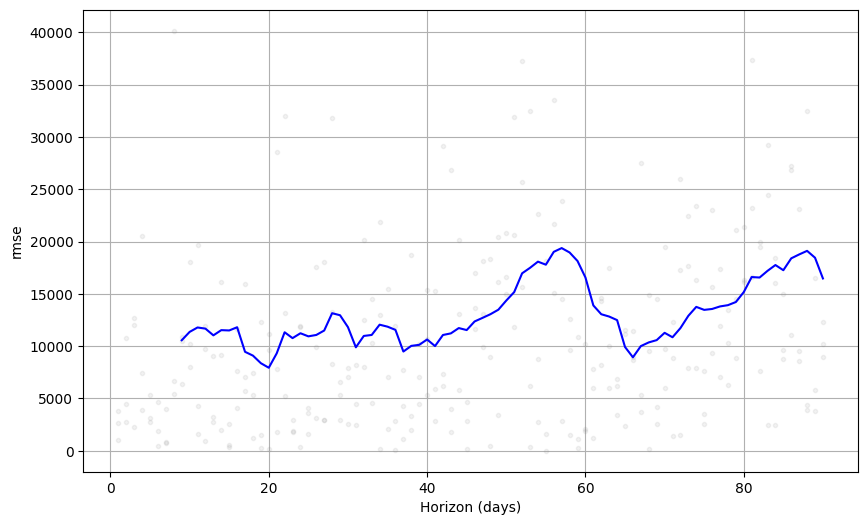

In [423]:
cv_plot_mul = plot_cross_validation_metric(cv_mul, metric = 'rmse')

In [424]:
df_performance_mul.describe().transpose()

count              mean                         std              min  \
horizon     82  49 days 12:00:00  23 days 19:33:58.568845364  9 days 00:00:00   
mse       82.0  179320667.268403             85506700.698847  62920721.807742   
rmse      82.0      13047.696814                  3031.55943      7932.258304   
mae       82.0      10488.212008                 3017.308611      6276.945093   
mape      82.0          0.473439                    0.173884          0.20724   
mdape     82.0          0.347317                    0.106927          0.15043   
smape     82.0           0.37888                      0.0929         0.231832   
coverage  82.0            0.6757                    0.169831         0.333333   

                       25%               50%               75%  \
horizon   29 days 06:00:00  49 days 12:00:00  69 days 18:00:00   
mse       120711161.438196  140109732.118064  223976427.117273   
rmse          10986.834463      11836.774173      14961.757786   
mae            8120.808062       9447.236911      12401.837347   
mape              0.326664           0.42368          0.643308   
mdape             0.250976          0.340032          0.416281   
smape             0.314682          0.350959           0.45294   
coverage          0.564815          0.722222          0.814815   

                       max  
horizon   90 days 00:00:00  
mse       375234950.893083  
rmse          19370.982187  
mae           16865.756011  
mape              0.796831  
mdape             0.600238  
smape             0.584458  
coverage          0.925926

The obtained metrics have significantly worsened when we divided into training and testing. This could be due to the limited time window we have. Additionally, the trend of the time series starts to rise in August, just when our training sample ends. This explains a poorer prediction of future values if we do not take into account this part of the sample to train the model, and therefore, we observe poorer metrics.

# 3. Catboost Model

## 3.1. Naïve Model

### Preprocessing

The models we are going to use next do not accept the date format, so it is necessary to perform some preprocessing of our variables.

In [425]:
df_agrupado.head()

Revenue  diferencias  dif_estacional
InvoiceDate                                       
2022-12-01   58960.79          NaN             NaN
2022-12-02   47748.38    -11212.41             NaN
2022-12-03   46943.71      -804.67             NaN
2022-12-04   39359.33     -7584.38             NaN
2022-12-05   31774.95     -7584.38             NaN

In [426]:
df_agrupado.reset_index(inplace=True)
df_ml1=df_agrupado[['InvoiceDate','Revenue']]

In [427]:
df_ml1['InvoiceDate']

0     2022-12-01
1     2022-12-02
2     2022-12-03
3     2022-12-04
4     2022-12-05
         ...    
369   2023-12-05
370   2023-12-06
371   2023-12-07
372   2023-12-08
373   2023-12-09
Name: InvoiceDate, Length: 374, dtype: datetime64[ns]

Creating a column for year, month and day.

In [428]:
df_ml1['año']=df_ml1.InvoiceDate.dt.year
df_ml1['mes']=df_ml1.InvoiceDate.dt.month
df_ml1['dia']=df_ml1.InvoiceDate.dt.day
df_ml1

<ipython-input-428-196b87afc5c7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



InvoiceDate   Revenue   año  mes  dia
0    2022-12-01  58960.79  2022   12    1
1    2022-12-02  47748.38  2022   12    2
2    2022-12-03  46943.71  2022   12    3
3    2022-12-04  39359.33  2022   12    4
4    2022-12-05  31774.95  2022   12    5
..          ...       ...   ...  ...  ...
369  2023-12-05  88741.96  2023   12    5
370  2023-12-06  56713.21  2023   12    6
371  2023-12-07  75439.16  2023   12    7
372  2023-12-08  82495.00  2023   12    8
373  2023-12-09  32451.00  2023   12    9

[374 rows x 5 columns]

In [429]:
df_ml1['lag_1'] = df_ml1['Revenue'].shift(1)
df_ml1['lag_2'] = df_ml1['Revenue'].shift(2)
df_ml1['lag_3'] = df_ml1['Revenue'].shift(3)
df_ml1['lag_7'] = df_ml1['Revenue'].shift(7)
df_ml1['lag_14'] = df_ml1['Revenue'].shift(14)

df_ml2=df_ml1.copy()

### Train & test split

In [430]:
columns_X = ['año', 'mes','dia']
column_y = 'Revenue'

In [431]:
train_size = int(0.7 * len(df_ml1))
df_ml1['type'] = 'train'
df_ml1.loc[train_size:, 'type'] = 'test'

In [432]:
train_X = df_ml1[df_ml1['type'] == 'train'][columns_X]
train_y = df_ml1[df_ml1['type'] == 'train'][column_y]
test_X = df_ml1[df_ml1['type'] == 'test'][columns_X]
test_y = df_ml1[df_ml1['type'] == 'test'][column_y]

### Adjusting the model and predicting

In [433]:
#instancio el modelo
model_cat = CatBoostRegressor(iterations=100,    # number of trees
                              learning_rate=0.1, # scale the contribution of each tree
                              depth=5)

In [434]:
model_cat.fit(train_X, train_y, verbose = False)
preds = model_cat.predict(test_X)
preds

array([35884.6188757 , 34656.60043319, 34638.35422185, 32442.88125478,
       32174.28022519, 31840.46547673, 30626.53222687, 29341.1148571 ,
       29937.88268923, 34236.37748833, 31723.77359344, 33193.4795307 ,
       31645.80882016, 23231.2121754 , 23650.79863715, 24640.35756043,
       38883.94412846, 27719.14103975, 24248.84392053, 24520.34618165,
       26886.46163399, 28901.30382768, 30045.47242611, 38988.22384106,
       22547.55535784, 19684.38825701, 23005.92069977, 23274.67400958,
       26866.38411349, 34703.58722355, 39074.81250537, 35884.6188757 ,
       34656.60043319, 34638.35422185, 32442.88125478, 32174.28022519,
       31840.46547673, 30626.53222687, 29341.1148571 , 29937.88268923,
       34236.37748833, 31723.77359344, 33193.4795307 , 23231.2121754 ,
       23650.79863715, 24640.35756043, 38883.94412846, 27719.14103975,
       24248.84392053, 24520.34618165, 26886.46163399, 28901.30382768,
       30045.47242611, 38988.22384106, 22547.55535784, 19684.38825701,
      

In [435]:
df_ml1['Rev_pred'] = np.concatenate([model_cat.predict(train_X), model_cat.predict(test_X)])
df_ml1

InvoiceDate   Revenue   año  mes  dia     lag_1     lag_2     lag_3  \
0    2022-12-01  58960.79  2022   12    1       NaN       NaN       NaN   
1    2022-12-02  47748.38  2022   12    2  58960.79       NaN       NaN   
2    2022-12-03  46943.71  2022   12    3  47748.38  58960.79       NaN   
3    2022-12-04  39359.33  2022   12    4  46943.71  47748.38  58960.79   
4    2022-12-05  31774.95  2022   12    5  39359.33  46943.71  47748.38   
..          ...       ...   ...  ...  ...       ...       ...       ...   
369  2023-12-05  88741.96  2023   12    5  24621.43  41142.75  57664.07   
370  2023-12-06  56713.21  2023   12    6  88741.96  24621.43  41142.75   
371  2023-12-07  75439.16  2023   12    7  56713.21  88741.96  24621.43   
372  2023-12-08  82495.00  2023   12    8  75439.16  56713.21  88741.96   
373  2023-12-09  32451.00  2023   12    9  82495.00  75439.16  56713.21   

        lag_7    lag_14   type      Rev_pred  
0         NaN       NaN  train  50673.304488  
1         NaN       NaN  train  50194.329918  
2         NaN       NaN  train  49977.940216  
3         NaN       NaN  train  47732.188285  
4         NaN       NaN  train  48136.713678  
..        ...       ...    ...           ...  
369  57165.19  49805.72   test  28942.989166  
370  72595.93  64089.82   test  28120.780114  
371  60126.96  80104.18   test  32392.088447  
372  52197.25  50978.63   test  30759.519763  
373  57664.07  50822.73   test  32774.361956  

[374 rows x 12 columns]

In [436]:
fig = px.line(df_ml1, x='InvoiceDate', y=['Revenue', 'Rev_pred'], line_dash='type')
fig.show()

### Evaluation

In [437]:
mae_train = mean_absolute_error(df_ml1[df_ml1['type'] == 'train']['Revenue'], df_ml1[df_ml1['type'] == 'train']['Rev_pred']).round(4)
mape_train = mean_absolute_percentage_error(df_ml1[df_ml1['type'] == 'train']['Revenue'], df_ml1[df_ml1['type'] == 'train']['Rev_pred']).round(4)
rmse_train = mean_squared_error(df_ml1[df_ml1['type'] == 'train']['Revenue'], df_ml1[df_ml1['type'] == 'train']['Rev_pred'], squared = True).round(4)


eval_train = [mae_train, mape_train, rmse_train]
display(pd.DataFrame(eval_train, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_train']))

# Evaluación de la parte de test

mae_test = mean_absolute_error(df_ml1[df_ml1['type'] == 'test']['Revenue'], df_ml1[df_ml1['type'] == 'test']['Rev_pred']).round(4)
rmse_test = mean_squared_error(df_ml1[df_ml1['type'] == 'test']['Revenue'], df_ml1[df_ml1['type'] == 'test']['Rev_pred'], squared = True).round(4)
mape_test = mean_absolute_percentage_error(df_ml1[df_ml1['type'] == 'test']['Revenue'], df_ml1[df_ml1['type'] == 'test']['Rev_pred']).round(4)

eval_test = [mae_test, mape_test, rmse_test]
pd.DataFrame(eval_test, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_test'])

eval_train
MAE   7.217332e+03
MAPE  3.963000e-01
RMSE  9.616980e+07

eval_test
MAE   1.878307e+04
MAPE  4.261000e-01
RMSE  6.160971e+08

In [438]:
px.line(df_ml1[['Rev_pred','Revenue']])

El modelo Naive no parece estar capturando las magnitud de las variaciones (si bien cuando la serie temporal aumenta/disminuye la predicción lo hace también, no lo hace en la misma medida).

## 3.2. Model with trend

If we model the growth rate, we might forecast the TS with greater accuracy.

In [439]:
df_ml2['inc_diff'] = df_ml2['Revenue'] - df_ml2['lag_1']
df_ml2

InvoiceDate   Revenue   año  mes  dia     lag_1     lag_2     lag_3  \
0    2022-12-01  58960.79  2022   12    1       NaN       NaN       NaN   
1    2022-12-02  47748.38  2022   12    2  58960.79       NaN       NaN   
2    2022-12-03  46943.71  2022   12    3  47748.38  58960.79       NaN   
3    2022-12-04  39359.33  2022   12    4  46943.71  47748.38  58960.79   
4    2022-12-05  31774.95  2022   12    5  39359.33  46943.71  47748.38   
..          ...       ...   ...  ...  ...       ...       ...       ...   
369  2023-12-05  88741.96  2023   12    5  24621.43  41142.75  57664.07   
370  2023-12-06  56713.21  2023   12    6  88741.96  24621.43  41142.75   
371  2023-12-07  75439.16  2023   12    7  56713.21  88741.96  24621.43   
372  2023-12-08  82495.00  2023   12    8  75439.16  56713.21  88741.96   
373  2023-12-09  32451.00  2023   12    9  82495.00  75439.16  56713.21   

        lag_7    lag_14  inc_diff  
0         NaN       NaN       NaN  
1         NaN       NaN -11212.41  
2         NaN       NaN   -804.67  
3         NaN       NaN  -7584.38  
4         NaN       NaN  -7584.38  
..        ...       ...       ...  
369  57165.19  49805.72  64120.53  
370  72595.93  64089.82 -32028.75  
371  60126.96  80104.18  18725.95  
372  52197.25  50978.63   7055.84  
373  57664.07  50822.73 -50044.00  

[374 rows x 11 columns]

In [440]:
px.line(df_ml2['inc_diff'], title='Diferencia absoluta de ingresos')

In [441]:
df_ml2['inc_per'] =  (df_ml2['Revenue'] / df_ml2['lag_1']) -1
px.line(df_ml2['inc_per'], title =  'Diferencia relativa de ingresos')

### Train - test split

In [442]:
df_ml2

InvoiceDate   Revenue   año  mes  dia     lag_1     lag_2     lag_3  \
0    2022-12-01  58960.79  2022   12    1       NaN       NaN       NaN   
1    2022-12-02  47748.38  2022   12    2  58960.79       NaN       NaN   
2    2022-12-03  46943.71  2022   12    3  47748.38  58960.79       NaN   
3    2022-12-04  39359.33  2022   12    4  46943.71  47748.38  58960.79   
4    2022-12-05  31774.95  2022   12    5  39359.33  46943.71  47748.38   
..          ...       ...   ...  ...  ...       ...       ...       ...   
369  2023-12-05  88741.96  2023   12    5  24621.43  41142.75  57664.07   
370  2023-12-06  56713.21  2023   12    6  88741.96  24621.43  41142.75   
371  2023-12-07  75439.16  2023   12    7  56713.21  88741.96  24621.43   
372  2023-12-08  82495.00  2023   12    8  75439.16  56713.21  88741.96   
373  2023-12-09  32451.00  2023   12    9  82495.00  75439.16  56713.21   

        lag_7    lag_14  inc_diff   inc_per  
0         NaN       NaN       NaN       NaN  
1         NaN       NaN -11212.41 -0.190167  
2         NaN       NaN   -804.67 -0.016852  
3         NaN       NaN  -7584.38 -0.161563  
4         NaN       NaN  -7584.38 -0.192696  
..        ...       ...       ...       ...  
369  57165.19  49805.72  64120.53  2.604257  
370  72595.93  64089.82 -32028.75 -0.360920  
371  60126.96  80104.18  18725.95  0.330187  
372  52197.25  50978.63   7055.84  0.093530  
373  57664.07  50822.73 -50044.00 -0.606631  

[374 rows x 12 columns]

In [443]:
columns_X = ['año', 'mes','dia', 'lag_1','lag_2','lag_7','lag_1_inc','lag_2_inc','lag_7_inc','lag_14_inc']
column_y = 'inc_per'

In [444]:
df_ml2['lag_1_inc'] = df_ml2['inc_per'].shift(1)
df_ml2['lag_2_inc'] = df_ml2['inc_per'].shift(2)
df_ml2['lag_7_inc'] = df_ml2['inc_per'].shift(7)
df_ml2['lag_14_inc'] = df_ml2['inc_per'].shift(14)

In [445]:
df_ml2=df_ml2.iloc[1:].reset_index(drop=True)

In [446]:
train_size = int(0.7 * len(df_ml2))
df_ml2['type'] = 'train'
df_ml2.loc[train_size:, 'type'] = 'test'

In [447]:
df_ml2

InvoiceDate   Revenue   año  mes  dia     lag_1     lag_2     lag_3  \
0    2022-12-02  47748.38  2022   12    2  58960.79       NaN       NaN   
1    2022-12-03  46943.71  2022   12    3  47748.38  58960.79       NaN   
2    2022-12-04  39359.33  2022   12    4  46943.71  47748.38  58960.79   
3    2022-12-05  31774.95  2022   12    5  39359.33  46943.71  47748.38   
4    2022-12-06  54830.46  2022   12    6  31774.95  39359.33  46943.71   
..          ...       ...   ...  ...  ...       ...       ...       ...   
368  2023-12-05  88741.96  2023   12    5  24621.43  41142.75  57664.07   
369  2023-12-06  56713.21  2023   12    6  88741.96  24621.43  41142.75   
370  2023-12-07  75439.16  2023   12    7  56713.21  88741.96  24621.43   
371  2023-12-08  82495.00  2023   12    8  75439.16  56713.21  88741.96   
372  2023-12-09  32451.00  2023   12    9  82495.00  75439.16  56713.21   

        lag_7    lag_14  inc_diff   inc_per  lag_1_inc  lag_2_inc  lag_7_inc  \
0         NaN       NaN -11212.41 -0.190167        NaN        NaN        NaN   
1         NaN       NaN   -804.67 -0.016852  -0.190167        NaN        NaN   
2         NaN       NaN  -7584.38 -0.161563  -0.016852  -0.190167        NaN   
3         NaN       NaN  -7584.38 -0.192696  -0.161563  -0.016852        NaN   
4         NaN       NaN  23055.51  0.725588  -0.192696  -0.161563        NaN   
..        ...       ...       ...       ...        ...        ...        ...   
368  57165.19  49805.72  64120.53  2.604257  -0.401561  -0.286510   1.773517   
369  72595.93  64089.82 -32028.75 -0.360920   2.604257  -0.401561   0.269932   
370  60126.96  80104.18  18725.95  0.330187  -0.360920   2.604257  -0.171759   
371  52197.25  50978.63   7055.84  0.093530   0.330187  -0.360920  -0.131883   
372  57664.07  50822.73 -50044.00 -0.606631   0.093530   0.330187   0.104734   

     lag_14_inc   type  
0           NaN  train  
1           NaN  train  
2           NaN  train  
3           NaN  train  
4           NaN  train  
..          ...    ...  
368    0.420643   test  
369    0.286796   test  
370    0.249874   test  
371   -0.363596   test  
372   -0.003058   test  

[373 rows x 17 columns]

In [448]:
train_X = df_ml2[df_ml2['type'] == 'train'][columns_X]
train_y = df_ml2[df_ml2['type'] == 'train'][column_y]
test_X = df_ml2[df_ml2['type'] == 'test'][columns_X]
test_y = df_ml2[df_ml2['type'] == 'test'][column_y]

### Adjusting the model and predicting

In [449]:
model_trends = CatBoostRegressor(iterations=100,
                          learning_rate=0.1,
                          depth=5)

In [450]:
model_trends.fit(train_X, train_y, verbose = False)
preds = model_trends.predict(test_X)
preds

array([-0.33305333, -0.27383457,  0.65975093,  0.20391604,  0.43614994,
       -0.14632846, -0.15226118,  0.07285629, -0.20473896,  1.20694573,
        0.33606342,  0.17219687, -0.03625836, -0.18417914, -0.24409261,
       -0.1619785 ,  0.72774614, -0.0791457 ,  0.05657887, -0.03114477,
        0.24697707, -0.02799366, -0.29296666,  0.25328412,  0.10593451,
       -0.25758684,  0.16250171, -0.18051961,  0.00346502,  0.26543103,
        0.43509996, -0.01256925, -0.54667765,  0.09530132, -0.29923482,
       -0.1653626 , -0.18800691,  0.14538953,  0.39409315, -0.31197644,
       -0.11249544, -0.31222889, -0.23556159,  0.05702875,  0.54977796,
       -0.189258  , -0.20741014, -0.24789281, -0.35054115, -0.37819033,
       -0.28770688,  0.58520525, -0.15803587, -0.0165864 ,  0.02201779,
       -0.12035082, -0.31727491, -0.23513651,  1.12262889, -0.11598142,
       -0.15832944, -0.09338324, -0.35683101, -0.47318468, -0.45979443,
        1.07623587, -0.21193716, -0.27534864, -0.08659122, -0.24

In [451]:
df_ml2

InvoiceDate   Revenue   año  mes  dia     lag_1     lag_2     lag_3  \
0    2022-12-02  47748.38  2022   12    2  58960.79       NaN       NaN   
1    2022-12-03  46943.71  2022   12    3  47748.38  58960.79       NaN   
2    2022-12-04  39359.33  2022   12    4  46943.71  47748.38  58960.79   
3    2022-12-05  31774.95  2022   12    5  39359.33  46943.71  47748.38   
4    2022-12-06  54830.46  2022   12    6  31774.95  39359.33  46943.71   
..          ...       ...   ...  ...  ...       ...       ...       ...   
368  2023-12-05  88741.96  2023   12    5  24621.43  41142.75  57664.07   
369  2023-12-06  56713.21  2023   12    6  88741.96  24621.43  41142.75   
370  2023-12-07  75439.16  2023   12    7  56713.21  88741.96  24621.43   
371  2023-12-08  82495.00  2023   12    8  75439.16  56713.21  88741.96   
372  2023-12-09  32451.00  2023   12    9  82495.00  75439.16  56713.21   

        lag_7    lag_14  inc_diff   inc_per  lag_1_inc  lag_2_inc  lag_7_inc  \
0         NaN       NaN -11212.41 -0.190167        NaN        NaN        NaN   
1         NaN       NaN   -804.67 -0.016852  -0.190167        NaN        NaN   
2         NaN       NaN  -7584.38 -0.161563  -0.016852  -0.190167        NaN   
3         NaN       NaN  -7584.38 -0.192696  -0.161563  -0.016852        NaN   
4         NaN       NaN  23055.51  0.725588  -0.192696  -0.161563        NaN   
..        ...       ...       ...       ...        ...        ...        ...   
368  57165.19  49805.72  64120.53  2.604257  -0.401561  -0.286510   1.773517   
369  72595.93  64089.82 -32028.75 -0.360920   2.604257  -0.401561   0.269932   
370  60126.96  80104.18  18725.95  0.330187  -0.360920   2.604257  -0.171759   
371  52197.25  50978.63   7055.84  0.093530   0.330187  -0.360920  -0.131883   
372  57664.07  50822.73 -50044.00 -0.606631   0.093530   0.330187   0.104734   

     lag_14_inc   type  
0           NaN  train  
1           NaN  train  
2           NaN  train  
3           NaN  train  
4           NaN  train  
..          ...    ...  
368    0.420643   test  
369    0.286796   test  
370    0.249874   test  
371   -0.363596   test  
372   -0.003058   test  

[373 rows x 17 columns]

In [452]:
#preds = model.predict(train_X) + model.predict(test_X)
df_ml2['Rev_pred_inc'] = np.concatenate([model_trends.predict(train_X), model_trends.predict(test_X)])
df_ml2

InvoiceDate   Revenue   año  mes  dia     lag_1     lag_2     lag_3  \
0    2022-12-02  47748.38  2022   12    2  58960.79       NaN       NaN   
1    2022-12-03  46943.71  2022   12    3  47748.38  58960.79       NaN   
2    2022-12-04  39359.33  2022   12    4  46943.71  47748.38  58960.79   
3    2022-12-05  31774.95  2022   12    5  39359.33  46943.71  47748.38   
4    2022-12-06  54830.46  2022   12    6  31774.95  39359.33  46943.71   
..          ...       ...   ...  ...  ...       ...       ...       ...   
368  2023-12-05  88741.96  2023   12    5  24621.43  41142.75  57664.07   
369  2023-12-06  56713.21  2023   12    6  88741.96  24621.43  41142.75   
370  2023-12-07  75439.16  2023   12    7  56713.21  88741.96  24621.43   
371  2023-12-08  82495.00  2023   12    8  75439.16  56713.21  88741.96   
372  2023-12-09  32451.00  2023   12    9  82495.00  75439.16  56713.21   

        lag_7    lag_14  inc_diff   inc_per  lag_1_inc  lag_2_inc  lag_7_inc  \
0         NaN       NaN -11212.41 -0.190167        NaN        NaN        NaN   
1         NaN       NaN   -804.67 -0.016852  -0.190167        NaN        NaN   
2         NaN       NaN  -7584.38 -0.161563  -0.016852  -0.190167        NaN   
3         NaN       NaN  -7584.38 -0.192696  -0.161563  -0.016852        NaN   
4         NaN       NaN  23055.51  0.725588  -0.192696  -0.161563        NaN   
..        ...       ...       ...       ...        ...        ...        ...   
368  57165.19  49805.72  64120.53  2.604257  -0.401561  -0.286510   1.773517   
369  72595.93  64089.82 -32028.75 -0.360920   2.604257  -0.401561   0.269932   
370  60126.96  80104.18  18725.95  0.330187  -0.360920   2.604257  -0.171759   
371  52197.25  50978.63   7055.84  0.093530   0.330187  -0.360920  -0.131883   
372  57664.07  50822.73 -50044.00 -0.606631   0.093530   0.330187   0.104734   

     lag_14_inc   type  Rev_pred_inc  
0           NaN  train     -0.090722  
1           NaN  train     -0.110185  
2           NaN  train     -0.008323  
3           NaN  train     -0.048812  
4           NaN  train      0.312581  
..          ...    ...           ...  
368    0.420643   test      0.830172  
369    0.286796   test     -0.153321  
370    0.249874   test     -0.283987  
371   -0.363596   test     -0.372211  
372   -0.003058   test     -0.213977  

[373 rows x 18 columns]

In [453]:
px.line(df_ml2, x = 'InvoiceDate', y = [ 'inc_per', 'Rev_pred_inc'], line_dash = 'type')

Since we have modified the TS to model a percentage change, we have to revert the transformation to predict the data in absolute terms. 

In [454]:
df_ml2['Rev_pred_inc_total'] = df_ml2['lag_1'] * (df_ml2['Rev_pred_inc'] + 1)
df_ml2

InvoiceDate   Revenue   año  mes  dia     lag_1     lag_2     lag_3  \
0    2022-12-02  47748.38  2022   12    2  58960.79       NaN       NaN   
1    2022-12-03  46943.71  2022   12    3  47748.38  58960.79       NaN   
2    2022-12-04  39359.33  2022   12    4  46943.71  47748.38  58960.79   
3    2022-12-05  31774.95  2022   12    5  39359.33  46943.71  47748.38   
4    2022-12-06  54830.46  2022   12    6  31774.95  39359.33  46943.71   
..          ...       ...   ...  ...  ...       ...       ...       ...   
368  2023-12-05  88741.96  2023   12    5  24621.43  41142.75  57664.07   
369  2023-12-06  56713.21  2023   12    6  88741.96  24621.43  41142.75   
370  2023-12-07  75439.16  2023   12    7  56713.21  88741.96  24621.43   
371  2023-12-08  82495.00  2023   12    8  75439.16  56713.21  88741.96   
372  2023-12-09  32451.00  2023   12    9  82495.00  75439.16  56713.21   

        lag_7    lag_14  inc_diff   inc_per  lag_1_inc  lag_2_inc  lag_7_inc  \
0         NaN       NaN -11212.41 -0.190167        NaN        NaN        NaN   
1         NaN       NaN   -804.67 -0.016852  -0.190167        NaN        NaN   
2         NaN       NaN  -7584.38 -0.161563  -0.016852  -0.190167        NaN   
3         NaN       NaN  -7584.38 -0.192696  -0.161563  -0.016852        NaN   
4         NaN       NaN  23055.51  0.725588  -0.192696  -0.161563        NaN   
..        ...       ...       ...       ...        ...        ...        ...   
368  57165.19  49805.72  64120.53  2.604257  -0.401561  -0.286510   1.773517   
369  72595.93  64089.82 -32028.75 -0.360920   2.604257  -0.401561   0.269932   
370  60126.96  80104.18  18725.95  0.330187  -0.360920   2.604257  -0.171759   
371  52197.25  50978.63   7055.84  0.093530   0.330187  -0.360920  -0.131883   
372  57664.07  50822.73 -50044.00 -0.606631   0.093530   0.330187   0.104734   

     lag_14_inc   type  Rev_pred_inc  Rev_pred_inc_total  
0           NaN  train     -0.090722        53611.755988  
1           NaN  train     -0.110185        42487.223430  
2           NaN  train     -0.008323        46552.977846  
3           NaN  train     -0.048812        37438.120308  
4           NaN  train      0.312581        41707.187238  
..          ...    ...           ...                 ...  
368    0.420643   test      0.830172        45061.456601  
369    0.286796   test     -0.153321        75135.925401  
370    0.249874   test     -0.283987        40607.387745  
371   -0.363596   test     -0.372211        47359.883253  
372   -0.003058   test     -0.213977        64842.936599  

[373 rows x 19 columns]

In [455]:
px.line(df_ml2, x = 'InvoiceDate', y = [ 'Revenue', 'Rev_pred_inc_total'], line_dash = 'type')

### Evaluation

In [456]:
mae_train = mean_absolute_error(df_ml2[df_ml2['type'] == 'train']['Revenue'], df_ml2[df_ml2['type'] == 'train']['Rev_pred_inc_total']).round(4)
mape_train = mean_absolute_percentage_error(df_ml2[df_ml2['type'] == 'train']['Revenue'], df_ml2[df_ml2['type'] == 'train']['Rev_pred_inc_total']).round(4)
rmse_train = mean_squared_error(df_ml2[df_ml2['type'] == 'train']['Revenue'], df_ml2[df_ml2['type'] == 'train']['Rev_pred_inc_total'], squared = True).round(4)


eval_train = [mae_train, mape_train, rmse_train]
display(pd.DataFrame(eval_train, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_train']))

# Evaluación de la parte de test

mae_test = mean_absolute_error(df_ml2[df_ml2['type'] == 'test']['Revenue'], df_ml2[df_ml2['type'] == 'test']['Rev_pred_inc_total']).round(4)
rmse_test = mean_squared_error(df_ml2[df_ml2['type'] == 'test']['Revenue'], df_ml2[df_ml2['type'] == 'test']['Rev_pred_inc_total'], squared = True).round(4)
mape_test = mean_absolute_percentage_error(df_ml2[df_ml2['type'] == 'test']['Revenue'], df_ml2[df_ml2['type'] == 'test']['Rev_pred_inc_total']).round(4)

eval_test = [mae_test, mape_test, rmse_test]
pd.DataFrame(eval_test, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_test'])

eval_train
MAE   5.136158e+03
MAPE  2.312000e-01
RMSE  5.141364e+07

eval_test
MAE   1.328555e+04
MAPE  3.027000e-01
RMSE  3.475047e+08

### Interpreting the model

This model fits the data much better than the previous models (both ARIMA and Prophet or Catboost Naive), although it does not seem to capture the more 'atypical' revenues in the test sample.

Text(0.5, 1.0, 'Feature Importance')

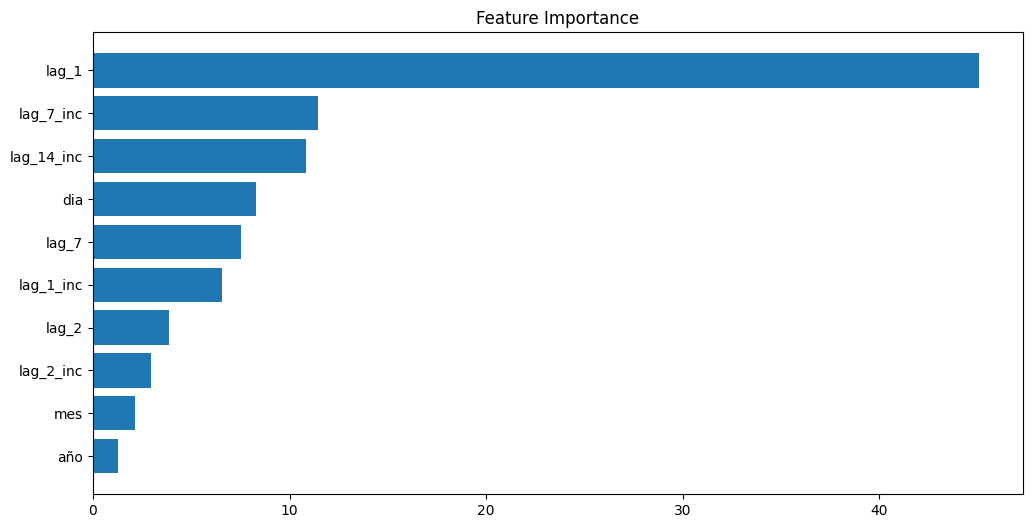

In [457]:
# Get the feature importanc
feature_importance = model_trends.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test_X.columns)[sorted_idx])
plt.title('Feature Importance')

In [458]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.1 MB/s eta 0:00:00


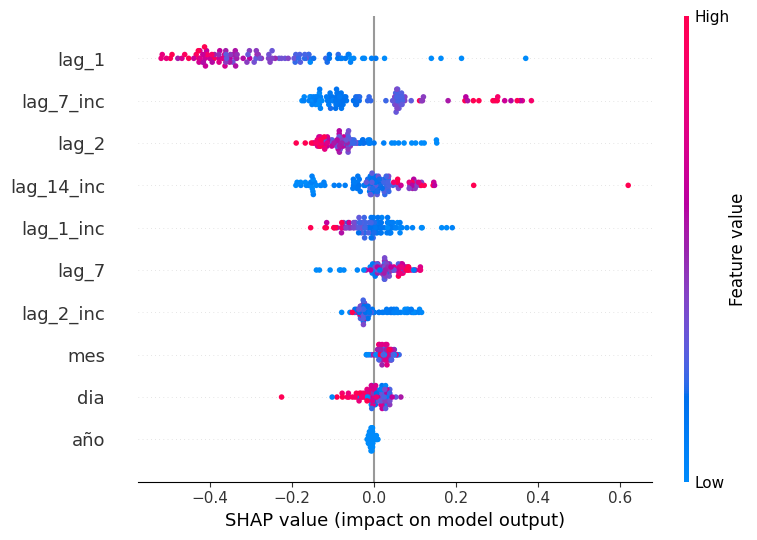

In [459]:
import shap
explainer = shap.TreeExplainer(model_trends)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

It is interesting that the `model.feature_importances_` method gives us a different importance ranking than the `shap` library. This is because, while the former is based on how features contribute to reducing the loss function during the model training, the latter is based on game theory, calculating how each feature contributes to the change in prediction compared to the model's average prediction.

In any case, the primary difference lies in the most explanatory variable in both cases. This means that high values immediately preceding (the day before) negatively influence the revenues of the following day.

The weekly lag is the second most important variable in both cases. This indicates seasonality in our data, as values from the previous week influence current values. Specifically, high previous values indicate high current values, and low past values indicate relatively low current values (thus, the impact of low values is less than that of high values from the previous week, although both affect current values).

# 4. XGBoost model

In [460]:
df_ml1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  374 non-null    datetime64[ns]
 1   Revenue      374 non-null    float64       
 2   año          374 non-null    int64         
 3   mes          374 non-null    int64         
 4   dia          374 non-null    int64         
 5   lag_1        373 non-null    float64       
 6   lag_2        372 non-null    float64       
 7   lag_3        371 non-null    float64       
 8   lag_7        367 non-null    float64       
 9   lag_14       360 non-null    float64       
 10  type         374 non-null    object        
 11  Rev_pred     374 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(1)
memory usage: 35.2+ KB


In [461]:
df_xgb=df_ml1[['InvoiceDate','Revenue']]

# creating a new column with the format of 'año-mes' 
df_xgb=df_xgb.set_index('InvoiceDate')

df_xgb.index = pd.DatetimeIndex(df_xgb.index).to_period('D')

display(df_xgb.info())
display(df_xgb.head())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 374 entries, 2022-12-01 to 2023-12-09
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  374 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


None

Revenue
InvoiceDate          
2022-12-01   58960.79
2022-12-02   47748.38
2022-12-03   46943.71
2022-12-04   39359.33
2022-12-05   31774.95

## Train-test split

In [462]:
y_train, y_test = temporal_train_test_split(df_xgb, test_size=24)
display(y_train.shape, y_train.head(2), y_train.tail(2))
display(y_test.shape, y_test.head(2), y_test.tail(2))

(350, 1)

Revenue
InvoiceDate          
2022-12-01   58960.79
2022-12-02   47748.38

Revenue
InvoiceDate           
2023-11-14   114419.89
2023-11-15    60807.29

(24, 1)

Revenue
InvoiceDate          
2023-11-16   65958.17
2023-11-17   61103.13

Revenue
InvoiceDate         
2023-12-08   82495.0
2023-12-09   32451.0

In [463]:
# for the moment, im going to perform an in sample prediction:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2023-11-16', '2023-11-17', '2023-11-18', '2023-11-19',
             '2023-11-20', '2023-11-21', '2023-11-22', '2023-11-23',
             '2023-11-24', '2023-11-25', '2023-11-26', '2023-11-27',
             '2023-11-28', '2023-11-29', '2023-11-30', '2023-12-01',
             '2023-12-02', '2023-12-03', '2023-12-04', '2023-12-05',
             '2023-12-06', '2023-12-07', '2023-12-08', '2023-12-09'],
            dtype='period[D]', name='InvoiceDate', is_relative=False)

## 4.1. Naïve Model

### Adjusting the model

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

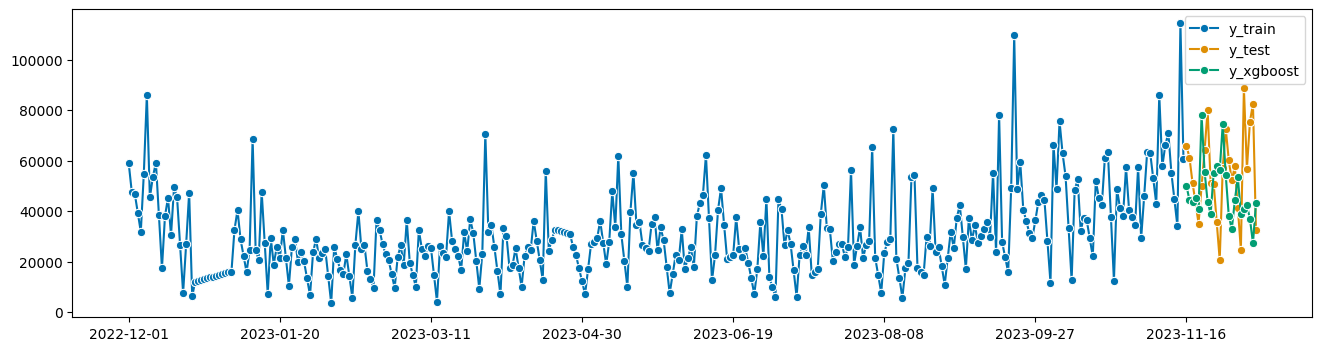

In [464]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive") # recursive, direct, mulitoutput
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

### Evaluating the model

In [465]:
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgboost, symmetric=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgboost)
rmse_xgb = mean_squared_error(y_test, y_pred_xgboost, squared=True)


eval_xgb = [mape_xgb, mae_xgb, rmse_xgb]
pd.DataFrame(eval_xgb, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

eval_xgb
MAPE  3.916165e-01
MAE   1.996219e+04
RMSE  5.799839e+08

## 4.2. Adjusting the model with transformers

In [466]:
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

forecaster = TransformedTargetForecaster(
    [
        #("Hampel_Filter", HampelFilter(window_length=7)),
        ('LogTransformer', LogTransformer()),
        ("deseasonalize_weekly", Deseasonalizer(model='multiplicative',sp=7)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(xgb_regressor, window_length=7, scitype='tabular-regressor'))
    ]
)

# adjusting the transformer to the training set
forecaster.fit(y_train)

# predicting in the test set
y_pred_transf = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

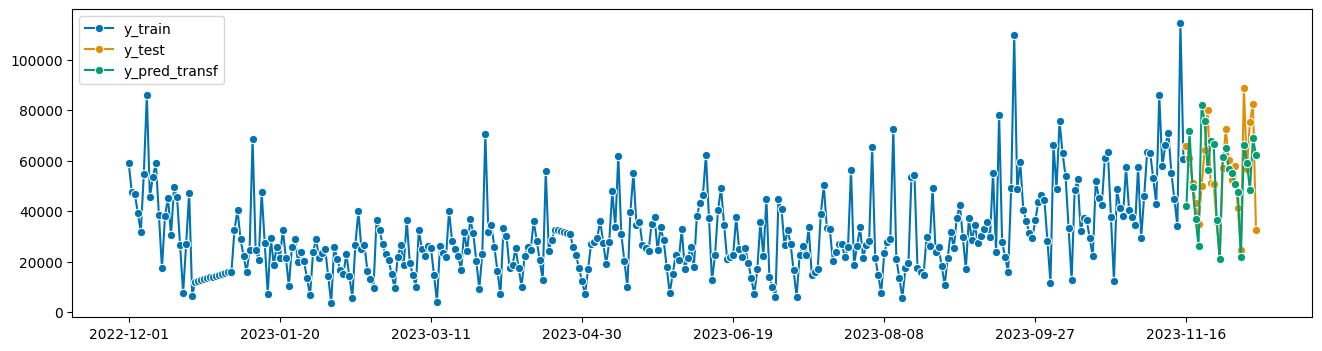

In [467]:
plot_series(y_train, y_test, y_pred_transf, labels=["y_train", "y_test", "y_pred_transf"])

In [468]:
mape_xgb_transf = mean_absolute_percentage_error(y_test, y_pred_transf, symmetric=False)
mae_xgb_transf = mean_absolute_error(y_test, y_pred_transf)
rmse_xgb_transf = mean_squared_error(y_test, y_pred_transf, squared=True)

eval_xgb_transf = [mape_xgb_transf, mae_xgb_transf, rmse_xgb_transf]
pd.DataFrame(eval_xgb_transf, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

eval_xgb
MAPE  2.156357e-01
MAE   1.175702e+04
RMSE  2.329015e+08

### Validation and hyperparameter tuning

In [469]:
validation_size = len(y_test)
validation_size

24

In [470]:
cv = ExpandingWindowSplitter(initial_window=90,
                                step_length=7,
                             fh=validation_size)

In [471]:
param_grid = {
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 200, 300, 500, 1000]
}


rscv = ForecastingRandomizedSearchCV(forecaster,
                                     cv=cv,
                                     param_distributions=param_grid,
                                     n_iter=100,
                                     random_state=42,
                                     error_score='raise',
                                     n_jobs=-1)

In [472]:
result_cv = rscv.fit(y_train)

y_pred_transf_cv = rscv.predict(fh=fh)

in ForecastingRandomizedSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

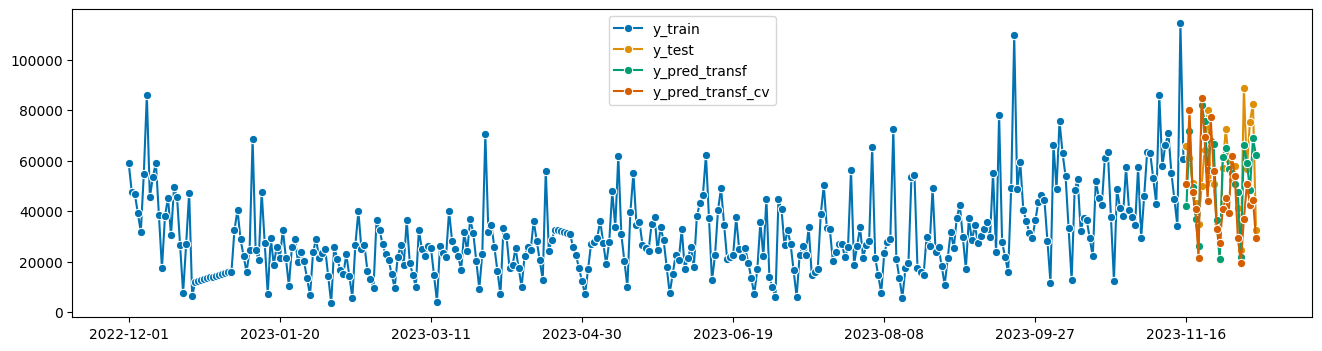

In [473]:
plot_series(y_train, y_test,  y_pred_transf, y_pred_transf_cv, labels=["y_train", "y_test", "y_pred_transf", "y_pred_transf_cv"])

In [474]:
mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, y_pred_transf_cv, symmetric=False)
mae_xgb_transf_cv = mean_absolute_error(y_test, y_pred_transf_cv)
rmse_xgb_transf_cv = mean_squared_error(y_test, y_pred_transf_cv, squared=True)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

eval_xgb_transf_cv
MAPE        2.810620e-01
MAE         1.657669e+04
RMSE        4.637032e+08

In [475]:
fhos = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2023-12-10", periods=90, freq="D")), is_relative=False
)
fhos

ForecastingHorizon(['2023-12-10', '2023-12-11', '2023-12-12', '2023-12-13',
             '2023-12-14', '2023-12-15', '2023-12-16', '2023-12-17',
             '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
             '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
             '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
             '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02',
             '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06',
             '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10',
             '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14',
             '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18',
             '2024-01-19', '2024-01-20', '2024-01-21', '2024-01-22',
             '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
             '2024-01-27', '2024-01-28', '2024-01-29', '2024-01-30',
             '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-03',
             '2024-02-04', 

In [476]:
rscv.fit(y_train)
y_pred_transf_oos = rscv.predict(fhos)

in ForecastingRandomizedSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

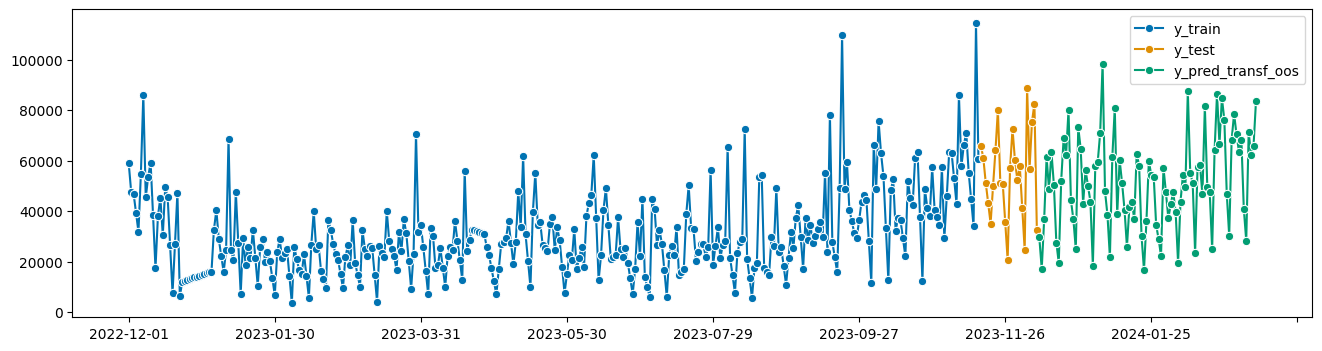

In [477]:
plot_series(y_train, y_test, y_pred_transf_oos, labels=["y_train", "y_test", "y_pred_transf_oos"])

# Technical conclusions


After trying various models, the following conclusions can be drawn:
- Overall, the best model is XGBoost, especially when certain transformations are applied to deal with the complexity of our data (for example, applying logarithms to handle scale issues).
- Arima and Autoarima models show quite poor evaluation metrics but serve as a good starting point.
- The Prophet model does not yield good results in evaluation metrics, although it improves significantly when introducing sales periods and holidays (people tend to buy more when they don't have to work). However, if we split the sample into training and evaluation subsets, the results worsen significantly, and adding complexity to the model with holidays and sales further deteriorates predictions. This may be due to the limited historical data window we have.

# Business conclussions

1. **Previous Day:**
   - Discovery: What happened yesterday matters. High or low sales from the previous day strongly impact today's sales, specifically, high values immediately preceding negatively influence the revenues of the following day.
   - Advice: Adjust strategies daily based on the previous day's sales. Swift actions guided by these patterns can maximize revenue.

2. **Previous Week:**
   - Observation: There is a weekly rhythm. Sales from the previous week have a significant influence on current sales, revealing weekly patterns.
   - Suggestion: Plan sales strategies considering weekly variations. Seize strong moments and adapt tactics to overcome potential downturns.

These observations highlight key opportunities to adjust strategies and maximize sales performance. By focusing on these two areas, we can capitalize on daily and weekly trends for ongoing success.